# Data Project 3: Detección de enfermedad cardíaca

- Fran Rosillo
- Victor Ruiz

### 1. Análisis Exploratorio

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import multiprocessing
import timeit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuración para seaborn

# sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': '10',
          'figure.figsize': (10, 6),
          'axes.labelsize': '10',
          'axes.titlesize':'10',
          'xtick.labelsize':'10',
          'ytick.labelsize':'10',
          'patch.linewidth': 0.0
         }

plt.rcParams.update(params)

### Exploración inicial

In [3]:
data = pd.read_csv("datasets/dataset.csv", sep=',', decimal='.')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       866 non-null    float64
 1   sex       866 non-null    float64
 2   cp        866 non-null    float64
 3   trestbps  809 non-null    float64
 4   chol      840 non-null    float64
 5   fbs       784 non-null    float64
 6   restecg   865 non-null    float64
 7   thalach   811 non-null    float64
 8   exang     811 non-null    float64
 9   oldpeak   806 non-null    float64
 10  slope     570 non-null    float64
 11  ca        297 non-null    float64
 12  thal      413 non-null    float64
 13  label     866 non-null    int64  
 14  split     866 non-null    object 
dtypes: float64(13), int64(1), object(1)
memory usage: 101.6+ KB


In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,split
0,56.0,1.0,2.0,126.0,166.0,0.0,1.0,140.0,0.0,0.0,NaN,NaN,NaN,0,val
1,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,0,train
2,57.0,1.0,2.0,180.0,285.0,1.0,1.0,120.0,0.0,0.8,NaN,NaN,NaN,1,train
3,66.0,1.0,3.0,110.0,213.0,1.0,2.0,99.0,1.0,1.3,2.0,NaN,NaN,0,train
4,67.0,1.0,3.0,152.0,212.0,0.0,2.0,150.0,0.0,0.8,2.0,0.0,7.0,1,train


Después de cargar el dataset y hacer una primera inspección de los datos, y antes de empezar el análisis, vamos a ver que representan cada una de las variables.

1. **age** (numérica) Edad del paciente, en años. 
---
2. **sex** (categórica) Sexo del paciente (0: mujer, 1: hombre). 
---
3. **cp** (categórica) Tipo de dolor de pecho experimentado por el paciente. 
    - 1: Angina típica. Relacionado con una disminución del suministro de sangre al corazón, generalmente desencadenado por el esfuerzo físico o el estrés emocional.
    - 2: Angina atípica. No cumple con todos los criterios para ser clasificado como angina típica.
    - 3: Dolor no-anginoso. No se considera angina ni está relacionado con el suministro de sangre al corazón.
    - 4: Asintomático. No se experimenta dolor en el pecho, pero puede haber otros síntomas relacionados con enfermedades cardíacas.
---    
4. **trestbps** (numérica) Presión arterial en reposo (en mm Hg). Una presión arterial elevada puede indicar un mayor riesgo de enfermedad cardíaca.
---
5. **chol** (numérica) Colesterol en sangre (en mg/dl).  Niveles elevados de colesterol pueden aumentar el riesgo de enfermedad cardíaca, ya que puede provocar el estrechamiento de los vasos sanguíneos principales.
---
6. **fbs** (categórica) Nivel de azúcar en sangre en ayunas > 120 mg/dl (1: sí, 0: no). Un nivel alto de azúcar en sangre en ayunas puede ser un signo de diabetes, que es un factor de riesgo conocido para enfermedades cardíacas.
---
7. **restecg** (categórica) Resultados de electrocardiograma en reposo. Puede ayudar a identificar problemas cardíacos, como arritmias o isquemias.
    - 0: normal
    - 1: presenta anormalidad de la onda ST-T (inversiones de la onda T y/o elevación o depresión del ST elevación o depresión del ST > 0,05 mV)
    - 2: presenta probable o definida hipertrofia ventricular izquierda
---
8. **thalach** (numérica) Frecuencia cardíaca máxima alcanzada en prueba de ejercicio. Una frecuencia cardíaca máxima reducida puede ser un signo de insuficiencia cardíaca.
---
9. **exang** (categórica) Angina inducida por el ejercicio (1: sí, 0: no). Puede ser un indicador de enfermedad arterial coronaria.
---
10. **oldpeak** (numérica) Depresión del segmento ST en ECG inducida por el ejercicio en relación con el reposo. Puede ser un indicador de isquemia, junto con la pendiente del segmento ST.
---
11. **slope** (categórica) Pendiente del segmento ST en ECG medido en esfuerzo máximo. La pendiente del segmento ST puede proporcionar información sobre la presencia de isquemia, un segmento ST plano o descendente junto con una depresión mayor que 1 puede indicar riesgo de isquemia. 
    - 1: pendiente ascendente
    - 2: plano
    - 3: pendiente descendente
---
12. **ca** (categórica) Resultado de la fluoroscopia, indica el número de vasos sanguíneos principales (0-3) que presentan estrechamiento. El estrechamiento de los vasos es un factor de riesgo de enfermedad cardíaca, ya que se reduce el riego sanguíneo en el corazón, pudiendo esto dar lugar a una angina de pecho, isquemia o insuficiencia cardíaca. Aunque el valor numérico de esta variable indica un valor "real", y podría tratarse como numérica, creemos que debería tratarse como una variable categórica, ya que es una variable discreta, y sus valores se pueden entender como niveles de riesgo de enfermedad, en orden creciente.

---
13. **thal** (categórica) Resultados de la prueba de esfuerzo con talio. Los resultados esta prueba, pueden revelar problemas en el suministro de sangre al corazón, lo que puede ser indicativo de enfermedad cardíaca. 
    - 3: normal (sin defecto)
    - 6: defecto reversible (una disminución temporal en el suministro de sangre al corazón, a menudo debido a un bloqueo parcial en las arterias coronarias)
    - 7: defecto fijo (una disminución permanente en el suministro de sangre al corazón, a menudo debido a un bloqueo completo en las arterias coronarias o daño cardíaco previo)

---
14. **label** Target a predecir, indica la ausencia (0) o el grado de enfermedad cardíaca (1-4)



In [5]:
# definimos que variables son categóricas (discretas), y cuales son numéricas (contínuas)
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = ['label']

In [6]:
# comprobamos si hay filas duplicadas
data[data.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,split
95,58.0,1.0,3.0,150.0,219.0,0.0,1.0,118.0,1.0,0.0,NaN,NaN,NaN,2,train


In [7]:
# borramos la fila duplicada
data = data.drop_duplicates()

In [8]:
# Valores únicos por cada variable
counts = { col: data[col].value_counts().shape[0] for col in list(data.columns)}
pd.DataFrame(counts, index=['Unique counts'])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,split
Unique counts,50,2,4,61,208,2,3,119,2,52,3,5,3,5,2


In [9]:
# Ahora veamos una muestra de los valores que tenemos en cada columna
vals = { col: [sorted(list(data[col].dropna().unique()))] for col in list(data.columns) }
pd.DataFrame(vals, index=['Unique values']).transpose()

,Unique values
age,"[28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35...."
sex,"[0.0, 1.0]"
cp,"[1.0, 2.0, 3.0, 4.0]"
trestbps,"[0.0, 80.0, 92.0, 94.0, 95.0, 96.0, 98.0, 100...."
chol,"[0.0, 85.0, 100.0, 117.0, 126.0, 129.0, 131.0,..."
fbs,"[0.0, 1.0]"
restecg,"[0.0, 1.0, 2.0]"
thalach,"[60.0, 63.0, 67.0, 69.0, 70.0, 71.0, 72.0, 73...."
exang,"[0.0, 1.0]"
oldpeak,"[-2.6, -2.0, -1.5, -1.1, -1.0, -0.9, -0.8, -0...."


In [10]:
# Vamos a ver la distribución de los valores no informados
df =  pd.DataFrame(data[numerical_vars + categorical_vars + target].isna().sum().to_dict(), index=[f"Missing values - total"])

for val in [0, 1, 2, 3, 4]:
    tmp = pd.DataFrame(data[data[numerical_vars + categorical_vars + target]['label'] == (val)].isna().sum().to_dict(), index=[f"Missing values - label = {val}"])
    df = pd.concat([df, tmp], axis=0)

df

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,label,split
Missing values - total,0,57,26,55,60,0,0,82,1,55,295,568,452,0,NaN
Missing values - label = 0,0,20,17,20,21,0,0,14,0,20,189,238,217,0,0.0
Missing values - label = 1,0,13,1,13,14,0,0,36,1,13,47,128,88,0,0.0
Missing values - label = 2,0,8,5,7,8,0,0,19,0,7,28,91,64,0,0.0
Missing values - label = 3,0,14,3,13,15,0,0,12,0,13,27,90,66,0,0.0
Missing values - label = 4,0,2,0,2,2,0,0,1,0,2,4,21,17,0,0.0


Para las columnas relacionadas con las pruebas de esfuerzo `slope`, `thal` o la fluoroscopia `ca` tenemos un valor de nulos muy alto. No parece ser un error, sino algo  "normal" (structurally missing data), ya que son pruebas que no son sencillas de realizar, y por tanto se prescriben solo a pacientes a los que se detecta alguna patología o factores de riesgo asociados a enfermedad cardíaca. Otra cosa que llama la atención es que el número de nulos para `thalach` y `exang` coinciden para todos los valores de `label`, lo que sugiere que las dos medidas se toman juntas, y que puede haber algún tipo de interacción entre ellas.

Contando los nulos por fila, vemos que hay 50 registros que tienen 7, 2 con 8, sobre 13 variables, es un número bastante alto. Deberíamos estudiar si queremos conservarlas. 


In [11]:
data.isnull().sum(axis=1).value_counts()

0    286
3    238
2    191
1     70
7     51
4     24
5      2
8      2
6      1
dtype: int64

Además de valores no informados, tenemos 0s en algunas variables numéricas. Para `oldpeak`, un 0 significa que no hay anomalías, pero para `chol` o `trestbps`, las medidas deberían ser siempre mayores que 0, un 0 es una medida errónea, por lo que deberíamos tratarlos como los valores no informados.

In [12]:
# Además de valores no informados, tenemos 0s en algunas variables numéricas
df = pd.DataFrame(data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].eq(0).sum().to_dict(), index=[f"Zero values - total"])

for val in [0, 1, 2, 3, 4]:
    tmp = pd.DataFrame(data[data['label'] == val][['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].eq(0).sum().to_dict(), index=[f"Zero values - label = {val}"])
    df = pd.concat([df, tmp], axis=0)

df

,age,trestbps,chol,thalach,oldpeak
Zero values - total,0,1,159,0,354
Zero values - label = 0,0,0,20,0,238
Zero values - label = 1,0,0,57,0,60
Zero values - label = 2,0,0,42,0,33
Zero values - label = 3,0,1,36,0,19
Zero values - label = 4,0,0,4,0,4


In [13]:
data[numerical_vars].describe()

,age,trestbps,chol,thalach,oldpeak
count,865.000000,808.000000,839.000000,810.000000,805.000000
mean,53.431214,132.070545,199.400477,137.717284,0.847702
std,9.475490,19.130575,109.722994,26.163654,1.071527
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,176.500000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,140.000000,0.500000
75%,60.000000,140.000000,267.500000,158.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


Aparte de los 0s, vemos que `oldpeak`  tiene valores negativos. Esto podría significar que en vez de depresión del segmento ST hay una elevación respecto a su nivel normal en reposo, lo que también podría indicar riesgo de enfermedad cardíaca en combinación con una pendiente plana o descendente. 

In [14]:
data[categorical_vars + target].astype(str).describe()

,sex,cp,fbs,restecg,exang,slope,ca,thal,label
count,865,865,865,865,865,865,865,865,865
unique,2,4,3,4,3,4,6,4,5
top,1.0,4.0,0.0,0.0,0.0,2.0,nan,nan,0
freq,682,464,658,520,498,320,568,452,399


Para `ca` y `label` el valor más frecuente es el NA, tendríamos que analizar si nos aportan información o si es mejor borrarlos.

### Análisis univariante

#### Variables categóricas

Empezamos con conteos totales

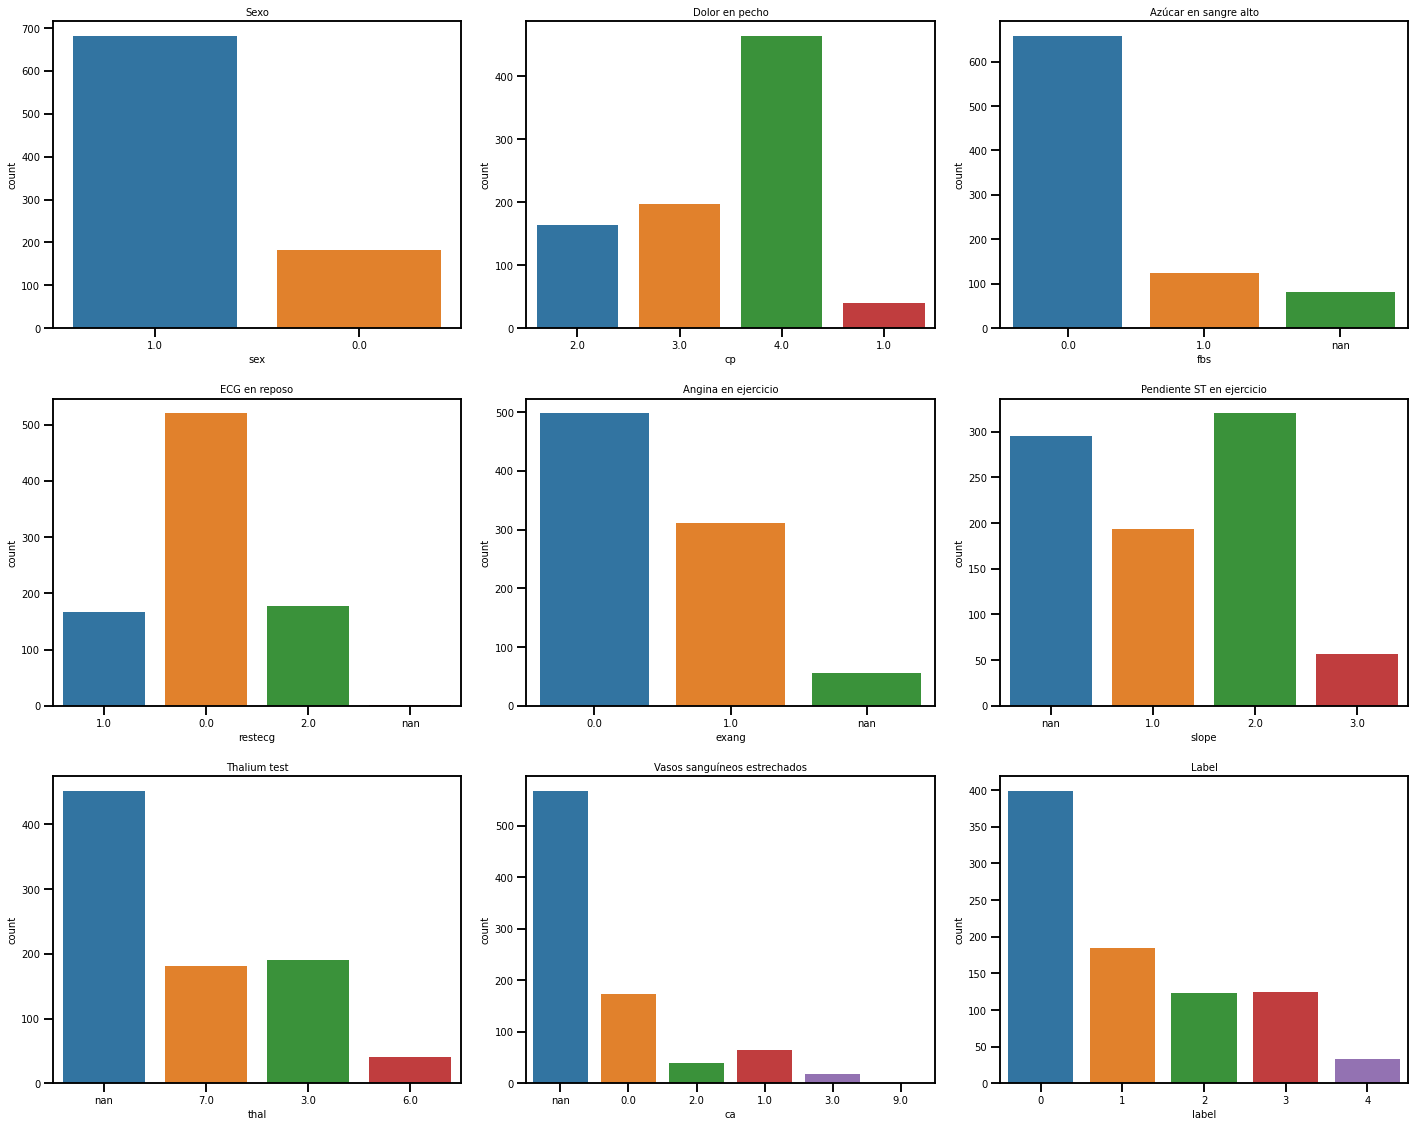

In [15]:
tmp = data.copy()
tmp[categorical_vars] = tmp[categorical_vars].astype('str')

fig, axes = plt.subplots(3, 3, figsize=(20,16))

sns.countplot(x='sex', data=tmp, ax=axes[0,0])
axes[0,0].set_title('Sexo')

sns.countplot(x='cp', data=tmp, ax=axes[0,1])
axes[0,1].set_title('Dolor en pecho')

sns.countplot(x='fbs',data=tmp, ax=axes[0,2])
axes[0,2].set_title('Azúcar en sangre alto')

sns.countplot(x='restecg', data=tmp, ax=axes[1,0])
axes[1,0].set_title('ECG en reposo')

sns.countplot(x='exang', data=tmp, ax=axes[1,1])
axes[1,1].set_title('Angina en ejercicio')

sns.countplot(x='slope',data=tmp, ax=axes[1,2])
axes[1,2].set_title('Pendiente ST en ejercicio')

sns.countplot(x='thal',  data=tmp, ax=axes[2,0])
axes[2,0].set_title('Thalium test')

sns.countplot(x='ca',  data=tmp, ax=axes[2,1])
axes[2,1].set_title('Vasos sanguíneos estrechados')

sns.countplot(x='label', data=data, ax=axes[2,2])
axes[2,2].set_title('Label')

plt.tight_layout()
plt.show()


Ahora los conteos agrupados por el valor del target. Para `ca` vemos que hay un valor de `9`, lo que parece un outlier o una medida incorrecta, ya que el resultado de la fluoroscopia debe estar entre `0` y `3`, y nadie tiene `9` vasos sanguíneos principales.

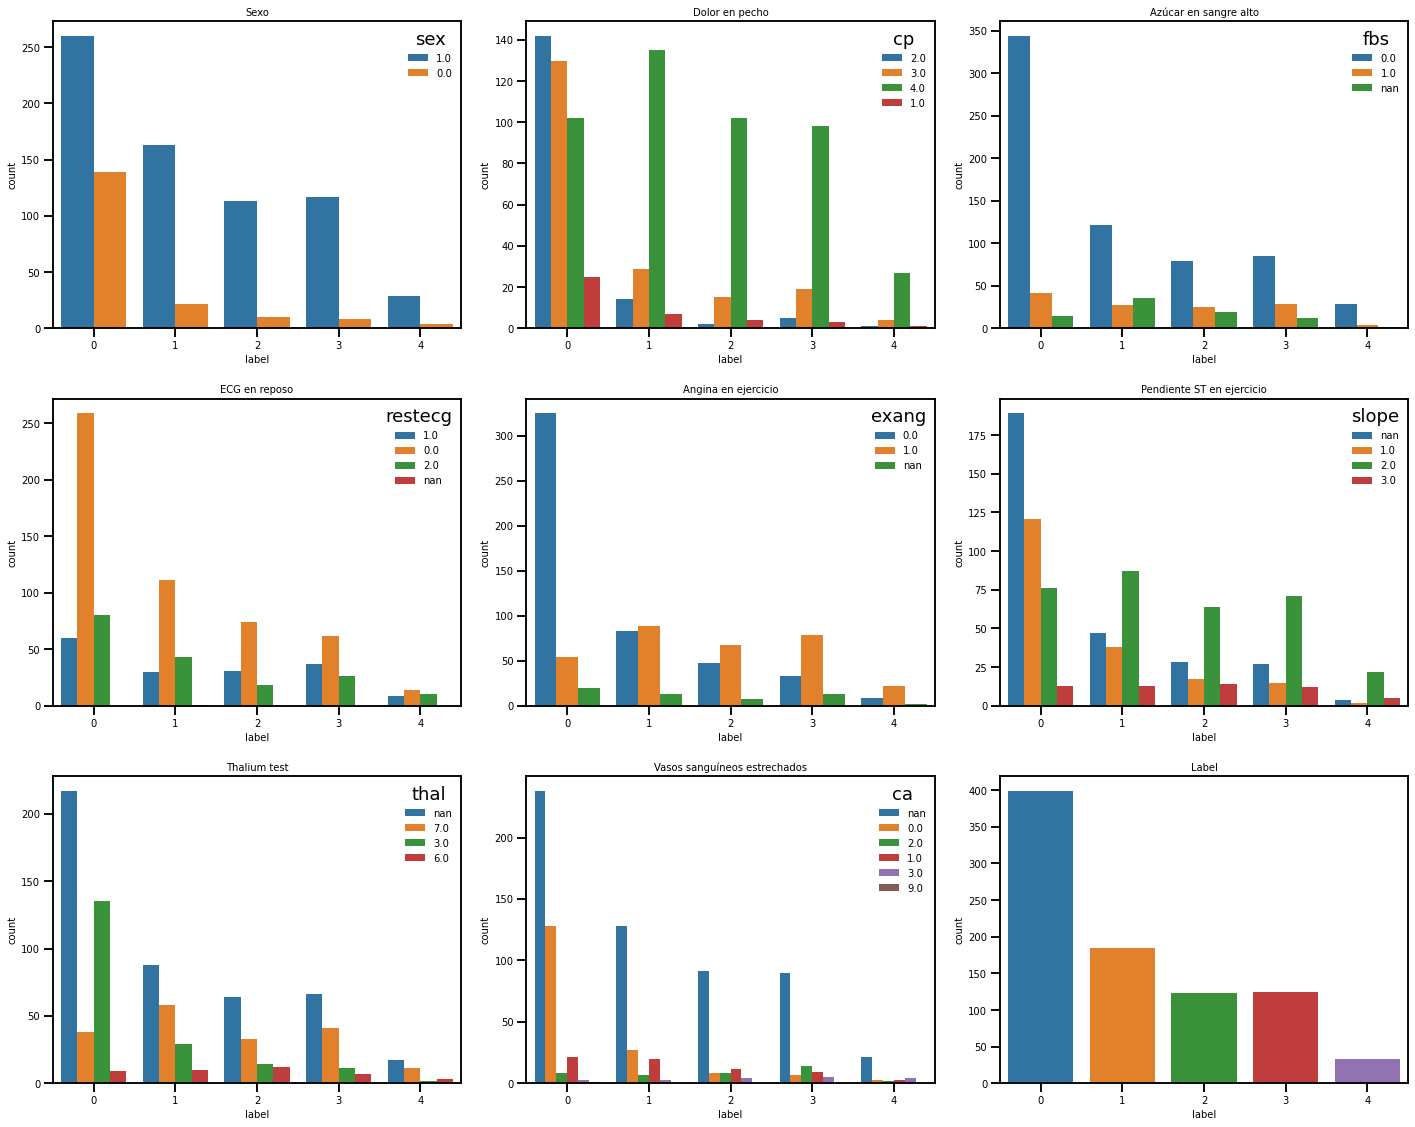

In [16]:
tmp = data.copy()
tmp[categorical_vars] = tmp[categorical_vars].astype('str')

fig, axes = plt.subplots(3, 3, figsize=(20,16))

sns.countplot(hue='sex', x='label', data=tmp, ax=axes[0,0])
axes[0,0].set_title('Sexo')

sns.countplot(hue='cp', x='label', data=tmp, ax=axes[0,1])
axes[0,1].set_title('Dolor en pecho')

sns.countplot(hue='fbs', x='label', data=tmp, ax=axes[0,2])
axes[0,2].set_title('Azúcar en sangre alto')

sns.countplot(hue='restecg', x='label', data=tmp, ax=axes[1,0])
axes[1,0].set_title('ECG en reposo')

sns.countplot(hue='exang', x='label', data=tmp, ax=axes[1,1])
axes[1,1].set_title('Angina en ejercicio')

sns.countplot(hue='slope', x='label', data=tmp, ax=axes[1,2])
axes[1,2].set_title('Pendiente ST en ejercicio')

sns.countplot(hue='thal', x='label', data=tmp, ax=axes[2,0])
axes[2,0].set_title('Thalium test')

sns.countplot(hue='ca', x='label', data=tmp, ax=axes[2,1])
axes[2,1].set_title('Vasos sanguíneos estrechados')

sns.countplot(x='label', data=data, ax=axes[2,2])
axes[2,2].set_title('Label')

plt.tight_layout()
plt.show()


Ahora veamos los conteos normalizados, mostrando el porcentaje de cada valor. Los valores nulos se muestran como "99", ya que si el valor no es numérico, no se incluye en el groupby. A simple vista, podemos observar que ciertos valores son más frecuentes para pacientes enfermos que para los no enfermos, p.e. los enfermos tienden a presentar dolor en el pecho en la prueba de esfuerzo `exang`, o a tener pendiente plana (2) en el segmento ST `slope`. 

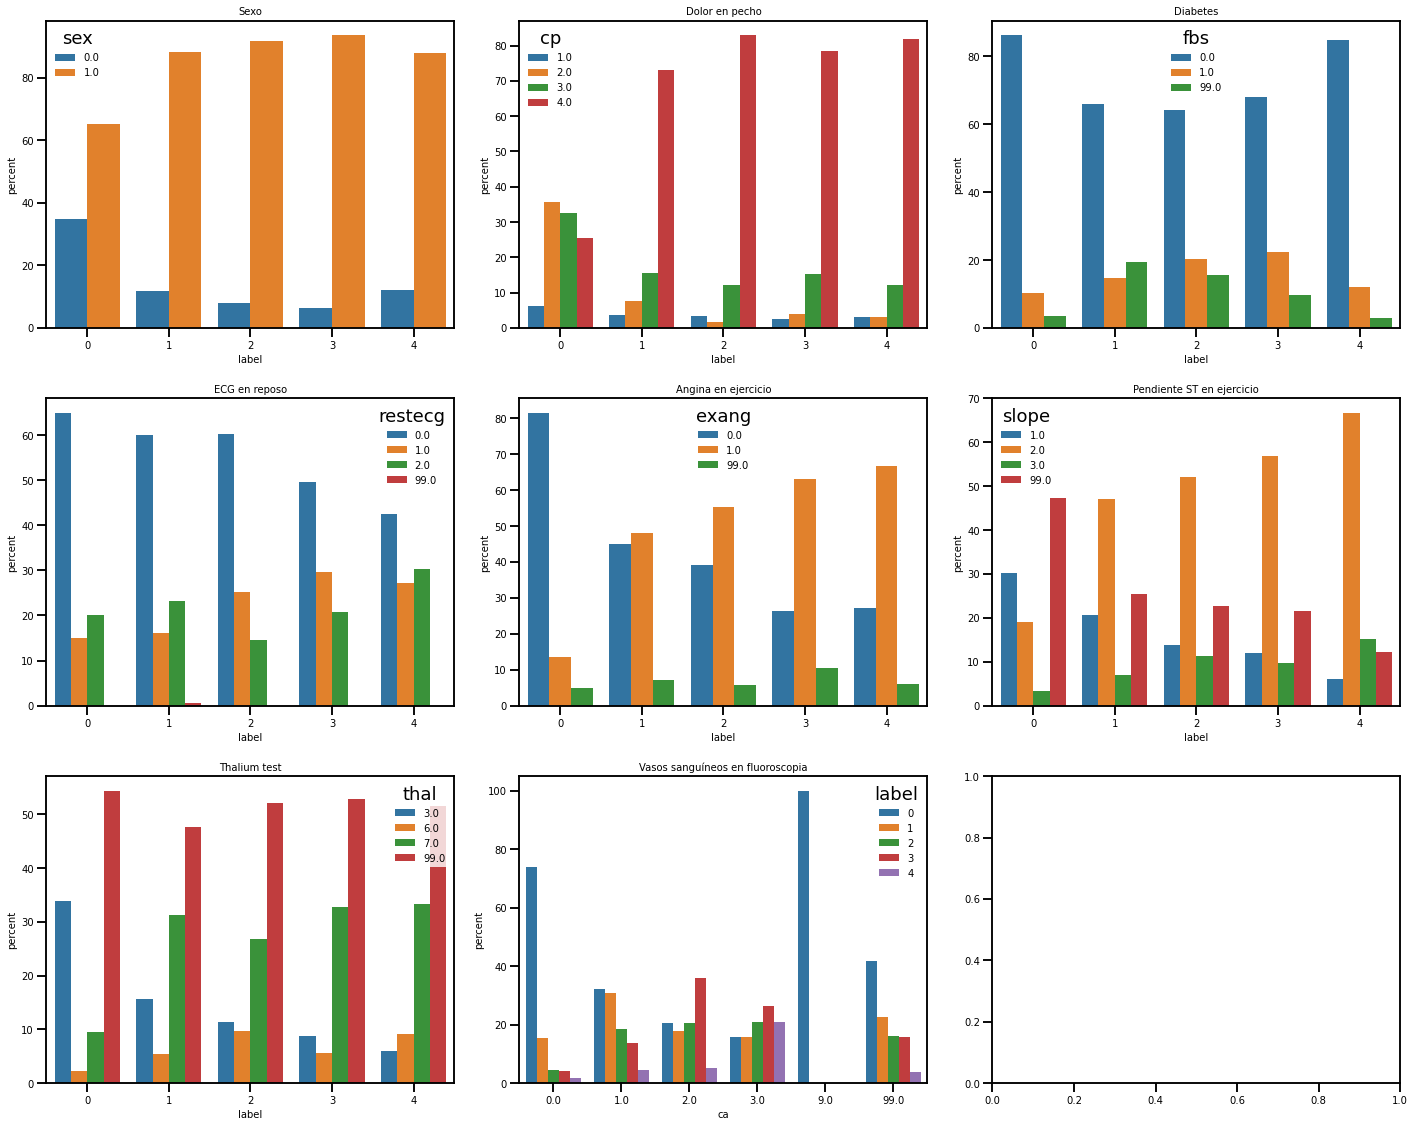

In [17]:
# Vamos a visualizar la distribución de variables categóricas
tmp = data.copy()
tmp[categorical_vars] = tmp[categorical_vars].replace(np.nan, 99)

fig, axes = plt.subplots(3, 3, figsize=(20,16))

(tmp.groupby('label')['sex']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='sex',ax=axes[0,0]))
axes[0,0].set_title('Sexo')

(tmp.groupby('label')['cp']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='cp',ax=axes[0,1]))
axes[0,1].set_title('Dolor en pecho')

(tmp.groupby('label')['fbs']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='fbs',ax=axes[0,2]))
axes[0,2].set_title('Diabetes')

(tmp.groupby('label')['restecg']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='restecg',ax=axes[1,0]))
axes[1,0].set_title('ECG en reposo')

(tmp.groupby('label')['exang']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='exang',ax=axes[1,1]))
axes[1,1].set_title('Angina en ejercicio')

(tmp.groupby('label')['slope']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='slope',ax=axes[1,2]))
axes[1,2].set_title('Pendiente ST en ejercicio')

(tmp.groupby('label')['thal']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='label',y='percent',hue='thal',ax=axes[2,0]))
axes[2,0].set_title('Thalium test')

(tmp.groupby('ca')['label']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='ca',y='percent',hue='label',ax=axes[2,1]))
axes[2,1].set_title('Vasos sanguíneos en fluoroscopia')


plt.tight_layout()
plt.show()


#### Variables numéricas

Ahora veamos las variables numéricas, primero con boxplots. Observamos bastantes outliers en `chol`, `trestbps` y `oldpeak`. Analizando en función del target, vemos que los pacientes enfermos tienden a tener valores más bajos de `thalach`, y más altos de `trestbps` y `scope`.

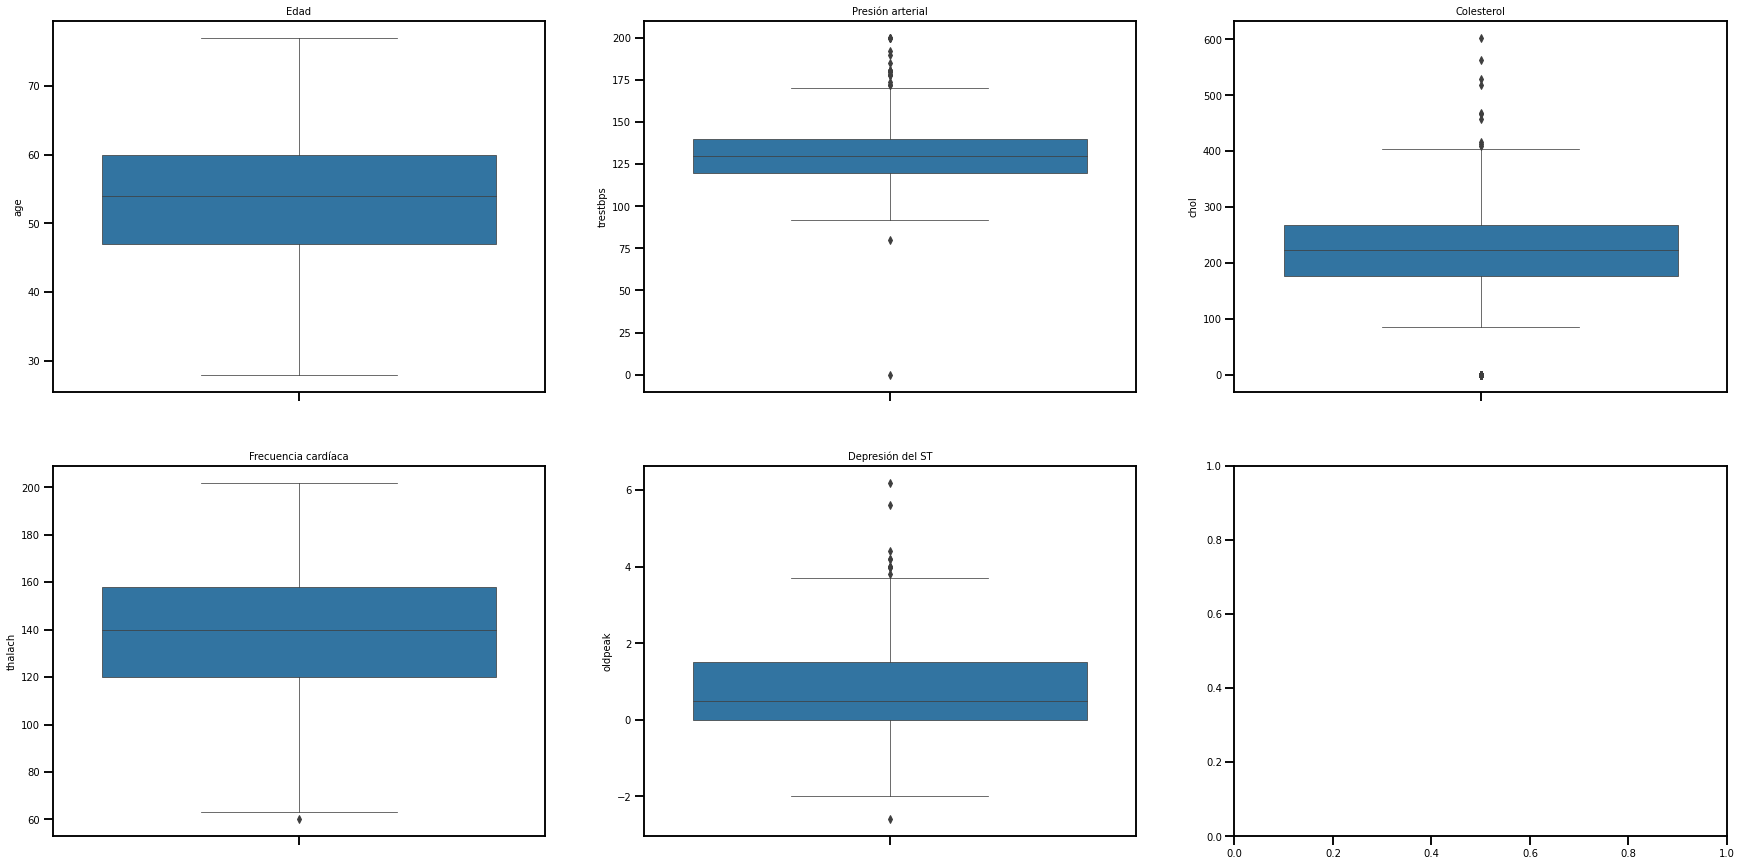

In [18]:
fig, axes = plt.subplots(2,3, figsize=(30,15))

sns.boxplot(y='age', data = data, ax=axes[0, 0], linewidth=0.75).set(title='Edad')
sns.boxplot(y='trestbps', data = data, ax=axes[0, 1], linewidth=0.75).set(title='Presión arterial')
sns.boxplot(y='chol', data = data, ax=axes[0, 2], linewidth=0.75).set(title='Colesterol')
sns.boxplot(y='thalach', data = data, ax=axes[1, 0], linewidth=0.75).set(title='Frecuencia cardíaca')
sns.boxplot(y='oldpeak', data = data, ax=axes[1, 1], linewidth=0.75).set(title='Depresión del ST')

plt.show()

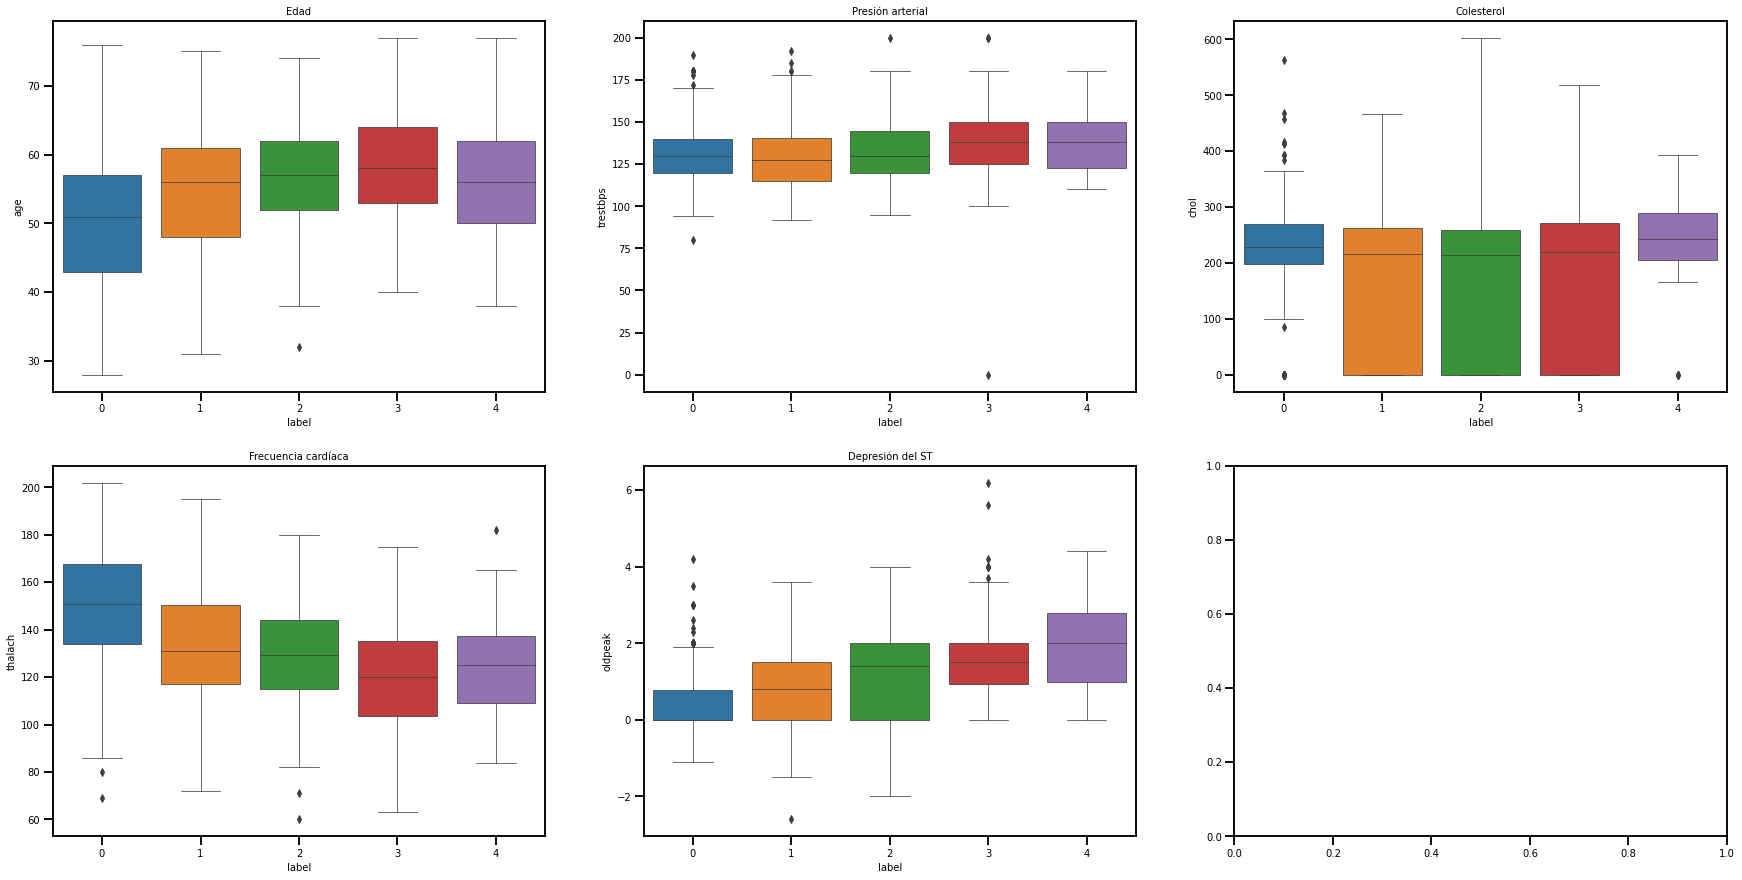

In [19]:
fig, axes = plt.subplots(2,3, figsize=(30,15))

sns.boxplot(x='label', y='age', data = data, ax=axes[0, 0], linewidth=0.75).set(title='Edad')
sns.boxplot(x='label', y='trestbps', data = data, ax=axes[0, 1], linewidth=0.75).set(title='Presión arterial')
sns.boxplot(x='label', y='chol', data = data, ax=axes[0, 2], linewidth=0.75).set(title='Colesterol')
sns.boxplot(x='label', y='thalach', data = data, ax=axes[1, 0], linewidth=0.75).set(title='Frecuencia cardíaca')
sns.boxplot(x='label', y='oldpeak', data = data, ax=axes[1, 1], linewidth=0.75).set(title='Depresión del ST')


plt.show()

Y ahora la función de densidad. En algunos casos, la distribución se aleja bastante de la normal `trestbps`, `thalach` y `oldpeak` tienen bastante "skewness". En el caso de `chol`, se debe a las medidas incorrectas de valore cero. En otras variables, como `age`, `oldpeak` o `trestbps`, parece que la distribución esté compuesta de dos grupos, con medias distintas, especialmente para los pacientes no enfermos. Esto podría deberse a que hay algunos pacientes más sanos y otros menos sanos, que tienen gran riesgo de tener una enfermedad cardíaca, pero aún no la han tenido. Estas desviaciones de la normalidad podrían ser perjudiciales para algunos modelos, 

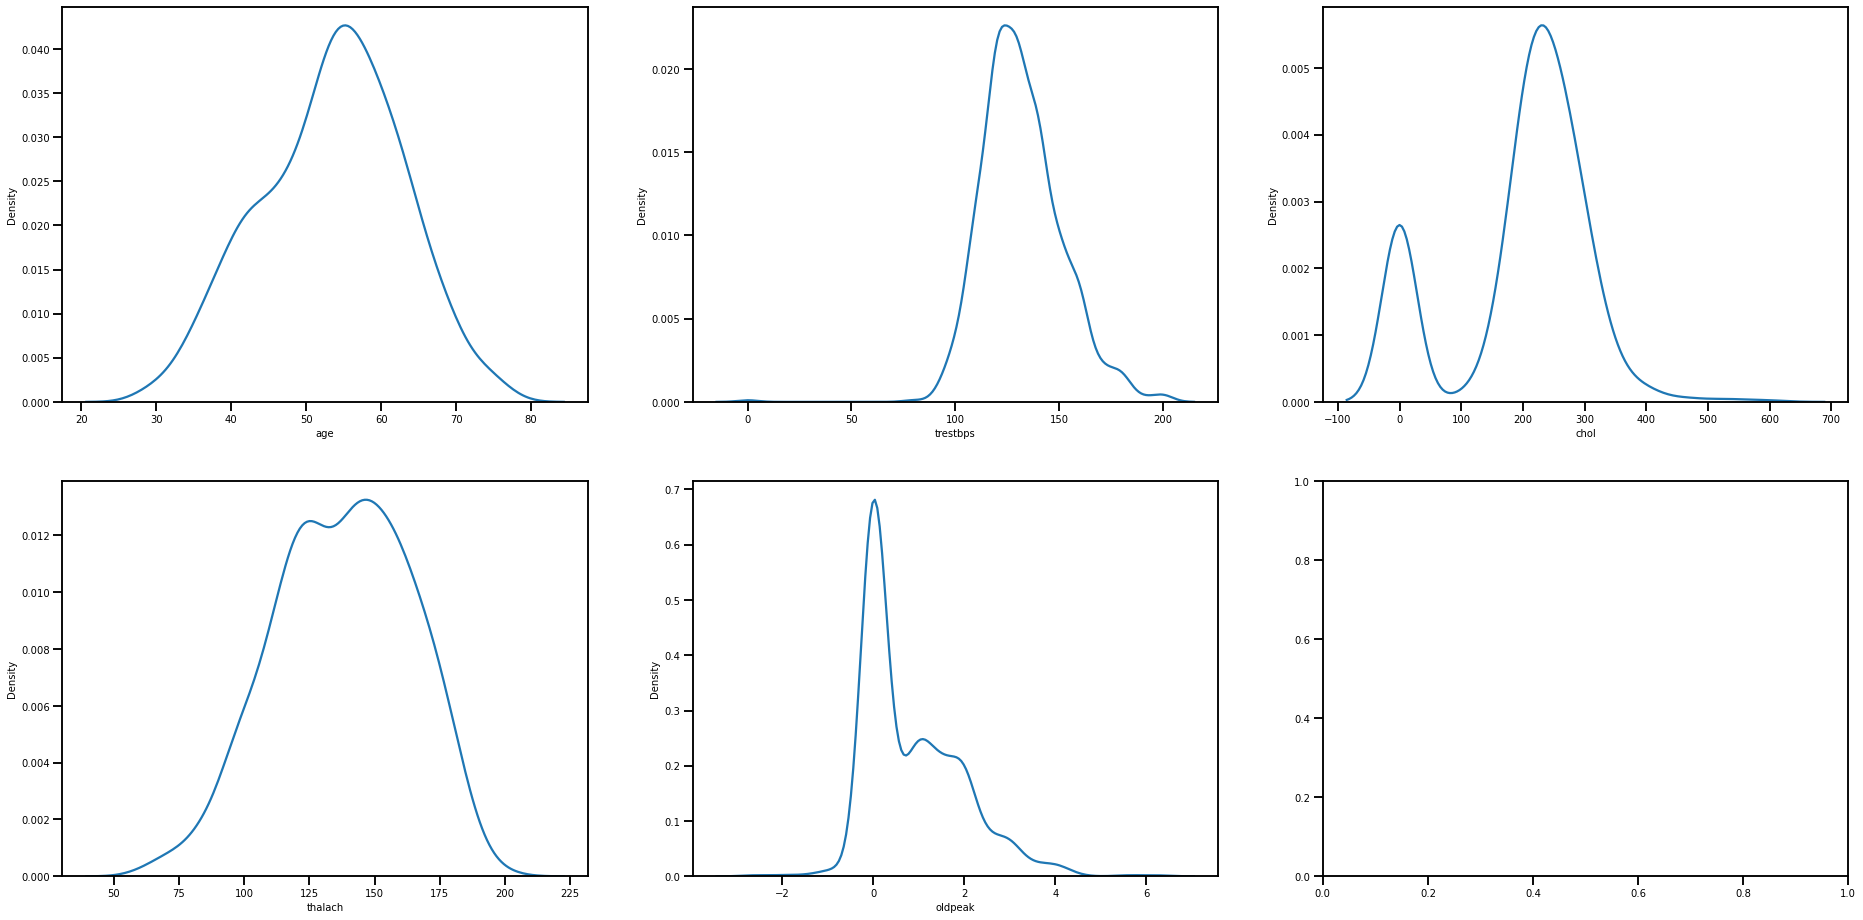

In [20]:
fig, axes = plt.subplots(2,3, figsize=(32,16))

sns.kdeplot(x='age', data=data, palette='coolwarm', ax=axes[0,0])
sns.kdeplot(x='trestbps', data=data, palette='coolwarm', ax=axes[0,1])
sns.kdeplot(x='chol', data=data, palette='coolwarm', ax=axes[0,2])
sns.kdeplot(x='thalach', data=data, palette='coolwarm', ax=axes[1,0])
sns.kdeplot(x='oldpeak', data=data, palette='coolwarm', ax=axes[1,1])

plt.show()

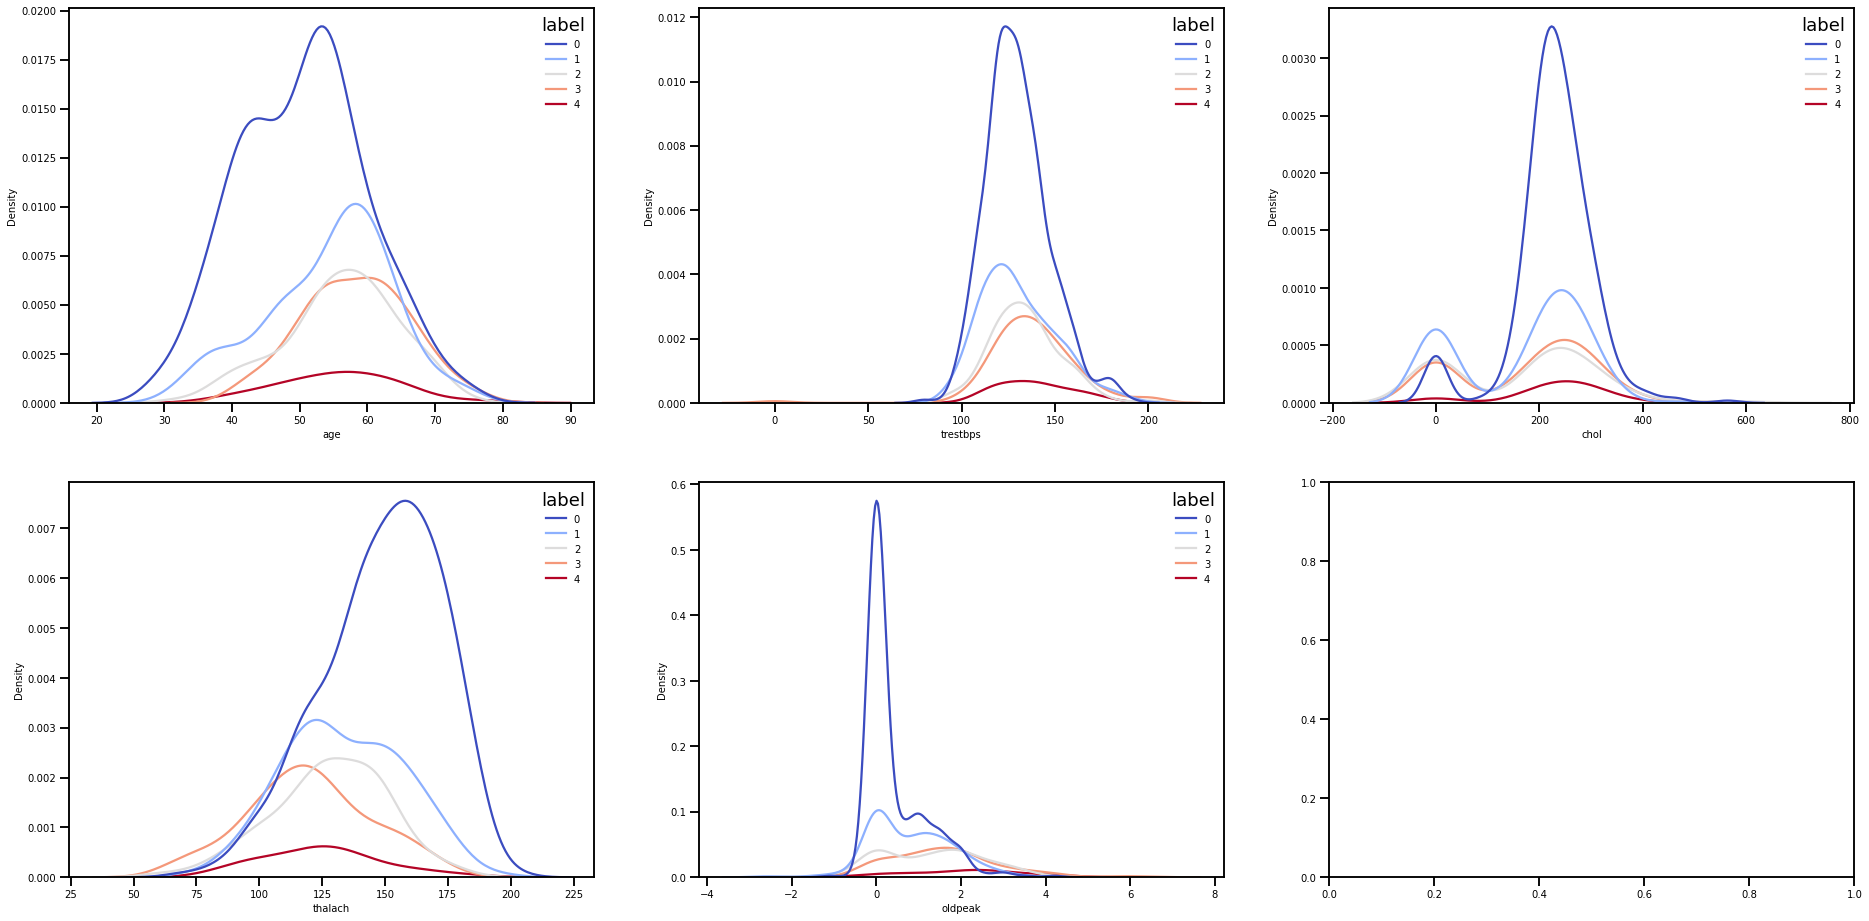

In [21]:
fig, axes = plt.subplots(2,3, figsize=(32,16))

sns.kdeplot(x='age', hue='label', data=data[numerical_vars + target], palette='coolwarm', ax=axes[0,0])
sns.kdeplot(x='trestbps', hue='label', data=data[numerical_vars + target], palette='coolwarm', ax=axes[0,1])
sns.kdeplot(x='chol', hue='label', data=data[numerical_vars + target], palette='coolwarm', ax=axes[0,2])
sns.kdeplot(x='thalach', hue='label', data=data[numerical_vars + target], palette='coolwarm', ax=axes[1,0])
sns.kdeplot(x='oldpeak', hue='label', data=data[numerical_vars + target], palette='coolwarm', ax=axes[1,1])

plt.show()

Con un Q-Q plot podemos ver más claramente como se desvían de la distribución normal las variables.

Text(0.5, 1.0, 'Q-Q plot Depresión ST')

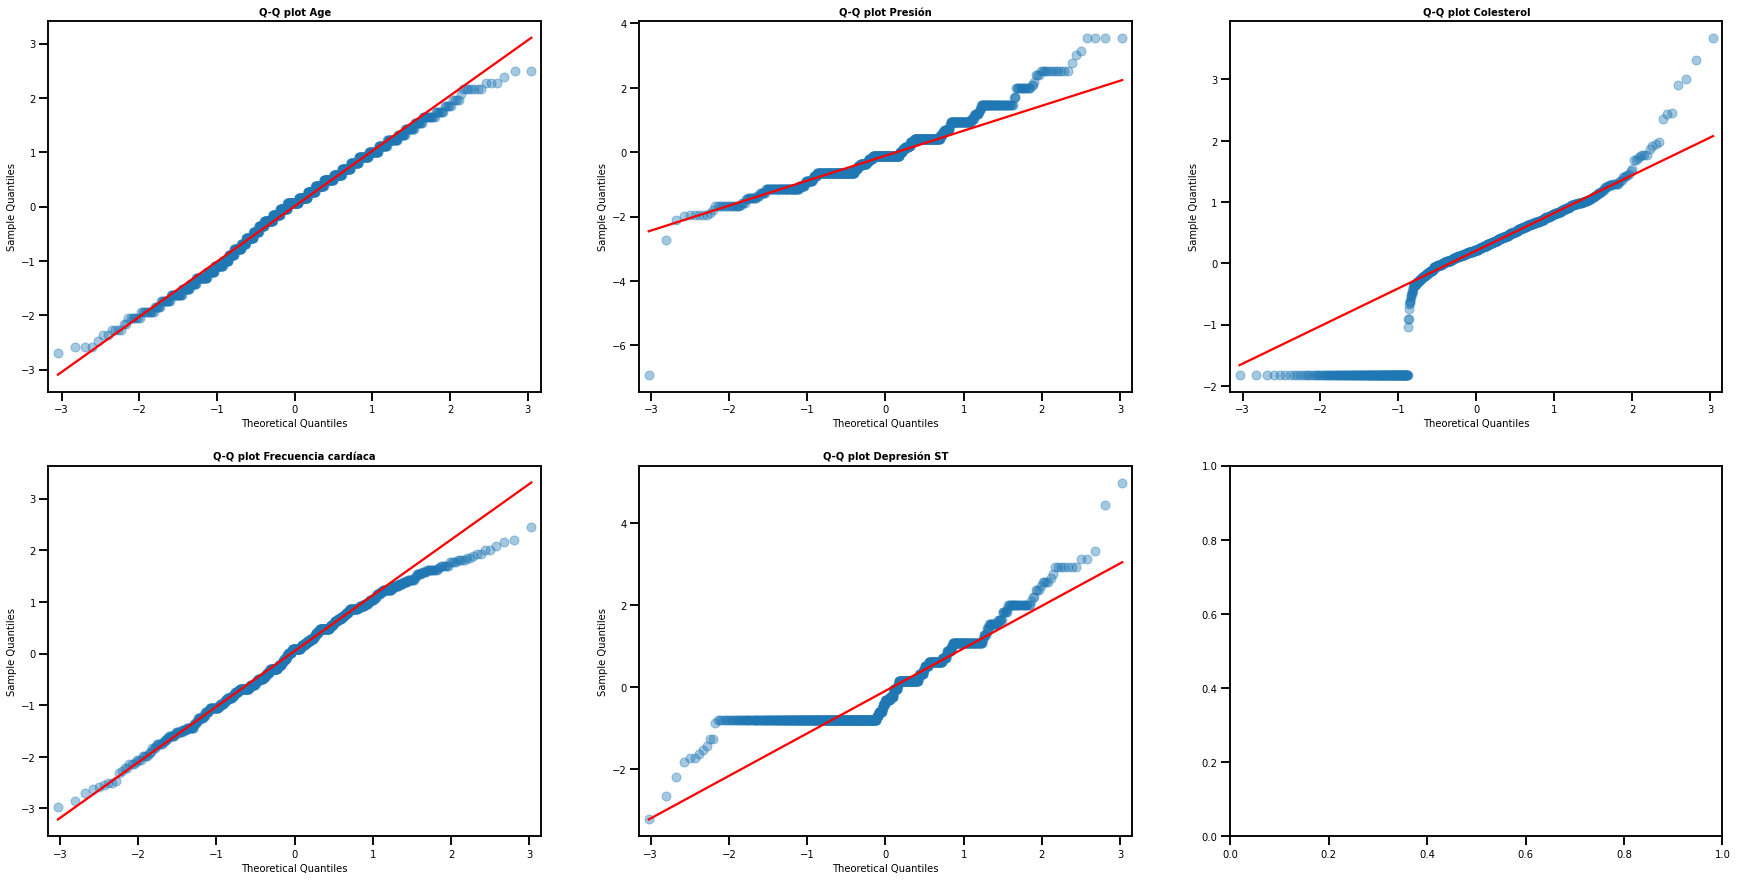

In [22]:

fig, axes = plt.subplots(2,3, figsize=(30,15))

sm.qqplot(data['age'], fit = True, line = 'q', alpha = 0.4, lw = 2, ax = axes[0, 0])
axes[0,0].set_title('Q-Q plot Age', fontsize = 10, fontweight = "bold")

sm.qqplot(data['trestbps'].dropna(), fit = True, line = 'q', alpha = 0.4, lw = 2, ax = axes[0, 1])
axes[0,1].set_title('Q-Q plot Presión', fontsize = 10, fontweight = "bold")

sm.qqplot(data['chol'].dropna(), fit = True, line = 'q', alpha = 0.4, lw = 2, ax = axes[0, 2])
axes[0,2].set_title('Q-Q plot Colesterol', fontsize = 10, fontweight = "bold")

sm.qqplot(data['thalach'].dropna(), fit = True, line = 'q', alpha = 0.4, lw = 2, ax = axes[1, 0])
axes[1,0].set_title('Q-Q plot Frecuencia cardíaca', fontsize = 10, fontweight = "bold")

sm.qqplot(data['oldpeak'].dropna() , fit = True, line = 'q', alpha = 0.4, lw = 2, ax = axes[1, 1])
axes[1,1].set_title('Q-Q plot Depresión ST', fontsize = 10, fontweight = "bold")

### Análisis Bivariante

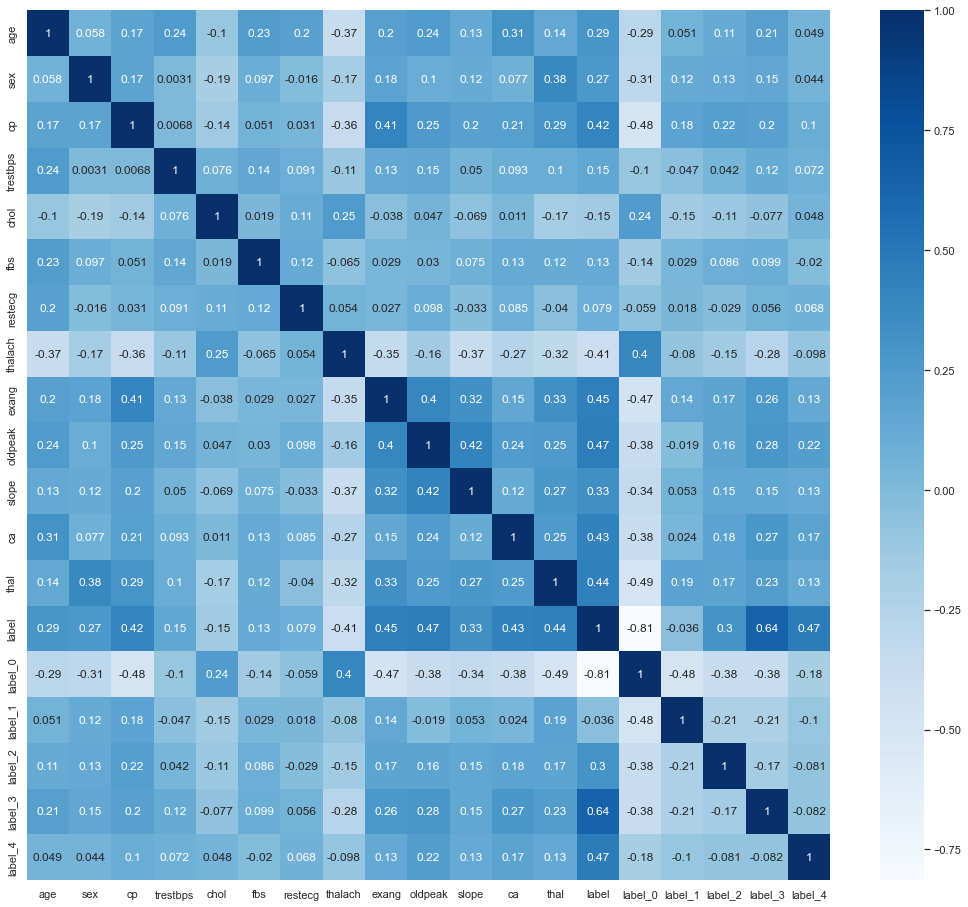

In [23]:
tmp = data.copy()

labels = []
for n in tmp['label'].unique():
    lab = f"label_{str(n)}"
    tmp[lab] = np.where(data['label'] == n, 1, 0)
    labels.append(lab)

sns.set(font_scale=1) 
plt.figure(figsize=(18,16))
ax = sns.heatmap(tmp.corr(method='pearson'),annot=True, cmap='Blues')


Casi todas las variables, excepto `restecg` parecen tener un grado de correlación significativo con `label`. Si nos ponemos a examinar la correlación con cada una de las clases de enfermedad identificar diferentes variables asociadas para cada una de las clases.

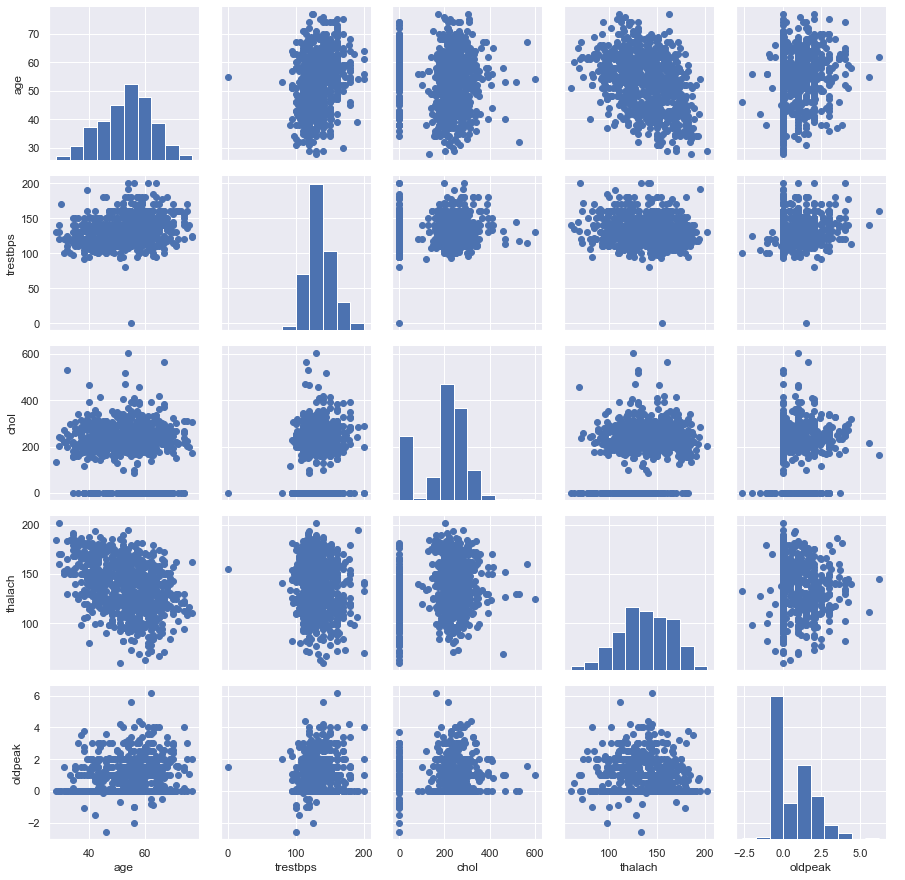

In [24]:
g = sns.PairGrid(data[numerical_vars])
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist)
g = g.add_legend()
plt.show()

No se aprecian interacciones significativas entre las variables, excepto la de `thalach` y `age`, algo que es de esperar, ya que la capacidad del corazón va disminuyendo con la edad, como lo indica la ecuación de la frecuencia máxima teórica: `200 - 0.7 * edad`.

Dividimos la edad en rangos para analizar como varían el resto de variables con la edad

In [25]:
data['age2'] = data['age'] // 10 
data['age2'].value_counts()

5.0    352
6.0    205
4.0    202
3.0     72
7.0     30
2.0      4
Name: age2, dtype: int64

#### Variables categóricas vs edad

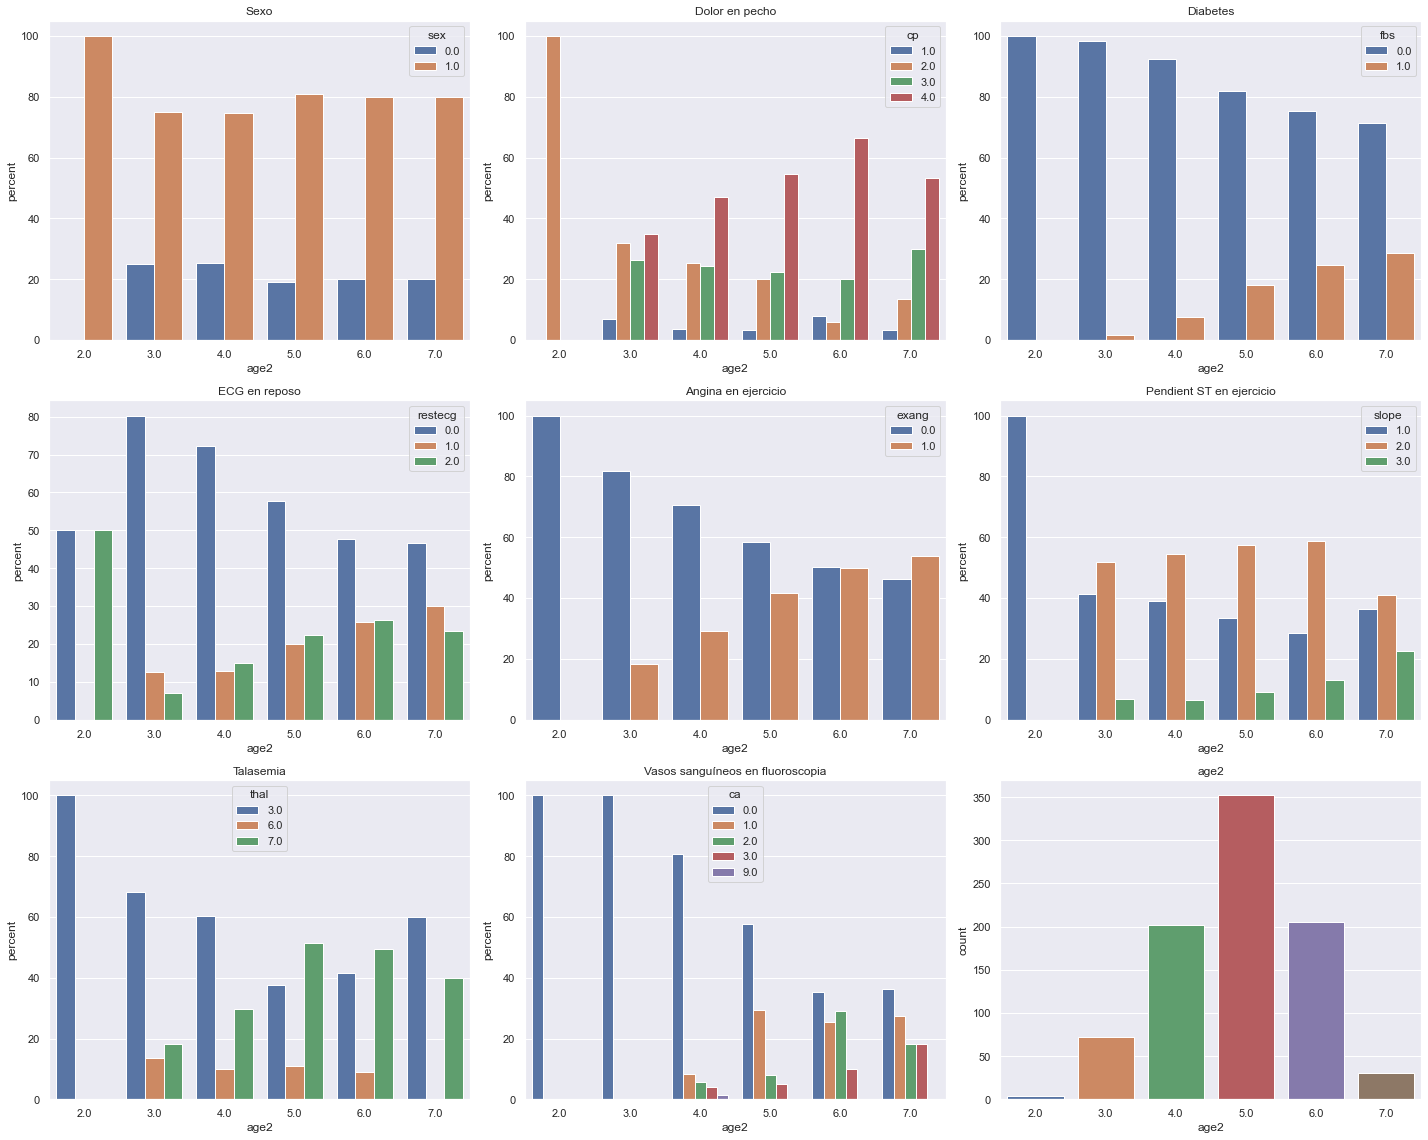

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(20,16))

(data.groupby('age2')['sex']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='sex',ax=axes[0,0]))
axes[0,0].set_title('Sexo')

(data.groupby('age2')['cp']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='cp',ax=axes[0,1]))
axes[0,1].set_title('Dolor en pecho')

(data.groupby('age2')['fbs']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='fbs',ax=axes[0,2]))
axes[0,2].set_title('Diabetes')

(data.groupby('age2')['restecg']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='restecg',ax=axes[1,0]))
axes[1,0].set_title('ECG en reposo')

(data.groupby('age2')['exang']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='exang',ax=axes[1,1]))
axes[1,1].set_title('Angina en ejercicio')

(data.groupby('age2')['slope']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='slope',ax=axes[1,2]))
axes[1,2].set_title('Pendient ST en ejercicio')

(data.groupby('age2')['thal']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='thal',ax=axes[2,0]))
axes[2,0].set_title('Talasemia')

(data.groupby('age2')['ca']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='age2',y='percent',hue='ca',ax=axes[2,1]))
axes[2,1].set_title('Vasos sanguíneos en fluoroscopia')

sns.countplot(x='age2', data=data, ax=axes[2,2])
axes[2,2].set_title('age2')

plt.tight_layout()
plt.show()

In [27]:
# Entre los diabéticos, es más común la angina de tipo 4
data[data['fbs'] == 1]['cp'].value_counts()

4.0    72
3.0    30
2.0    15
1.0     8
Name: cp, dtype: int64

Text(0.5, 1.0, 'CP (fbs == 1)')

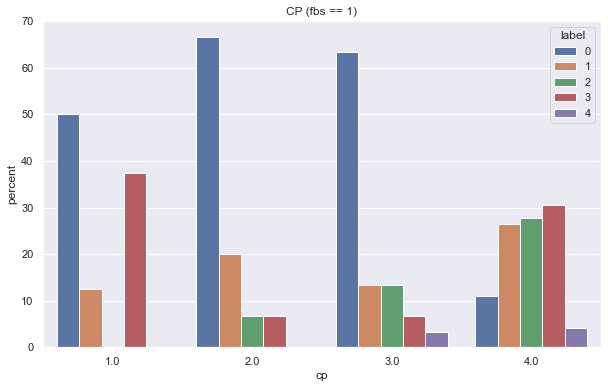

In [28]:
fig = plt.figure(figsize=(10,6))

(data[(data['fbs'] == 1)].groupby('cp')['label']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='cp',y='percent',hue='label'))

fig.axes[0].set_title('CP (fbs == 1)')

Text(0.5, 1.0, 'CP (restecg in [1,2])')

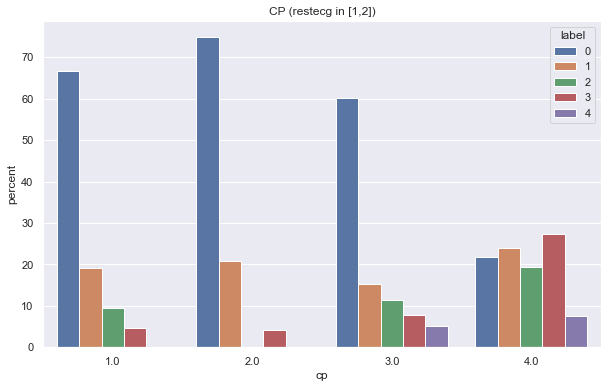

In [29]:
fig = plt.figure(figsize=(10,6))

(data[(data['restecg'] == 1) | (data['restecg'] == 2)].groupby('cp')['label']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x='cp',y='percent',hue='label'))
fig.axes[0].set_title('CP (restecg in [1,2])')

**Dolor en pecho (cp)**

- La angina típica (1) es la que menor % de incidencia tiene, normalmente se debe a esfuerzo físico o estrés emocional.
- La angina atípica (2) es el caso más frecuente en pacientes sanos. 
- El % de dolor no anginoso (3) no tiene mucha variación con la edad
- Para mayor edad, aumenta el % de asintomáticos (4), lo que se explica porque esta patología puede ser más común en ciertos grupos de población, como mujeres, personas mayores o diabéticos.
- El % de angina atípica (2) desciende a partir de los 60 años. 
- La angina de tipo 4 por sí sola no es un buen predictor de riesgo de enfermedad, pero cuando un paciente presenta también algún otro factor de riesgo, como por ejemplo, diabetes o alguna anomalía en el ECG, aumenta la probabilidad de enfermedad para esa persona.


**Azúcar en sangre (fbs)**

- El número de casos aumenta con la edad, algo normal
- No parece tener mucha correlación con la enfermedad cardíaca por sí solo, pero los pacientes que también tienen angina de pecho de tipo 4, presentan más riesgo de enfermedad. 

**ECG (restecg)**

- Aumentan los diágnosticos de 1 o 2 con la edad
- Para el rango de 20-30 años tenemos 50% de casos de tipo 2, lo que parece un outlier

**Dolor de pecho en ejercicio (exang)**

- Aumenta el número de casos con la edad, y también aumenta el número de valores no informados

**Pendiente ST (slope)**

- El % de casos que están más relacionados con la enfermedad (2 y 3)  aumentan con la edad

**Thalium test (thal)** 

- El % de casos totales que están más ligados a efermedad cardíaca (6 y 7) aumentan con la edad

**Fluorosopia (ca)**

- El % de casos totales que están más ligados a efermedad cardíaca (1, 2 y 3) aumentan con la edad
- El % de pacientes con resultado negativo (0) sobre el total de los pacientes a los que se les practica la prueba, disminuye con la edad


#### Variables numéricas vs edad

**Thalach**

In [30]:
data[data['label'] == 0].groupby(['age2'])['thalach'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,2.0,4,160.0,179.250000,202.0
1,3.0,49,98.0,161.291667,192.0
2,4.0,123,80.0,153.675000,194.0
3,5.0,158,69.0,144.703947,190.0
4,6.0,56,86.0,138.297872,179.0
5,7.0,9,112.0,127.875000,162.0


In [31]:
data[data['label'] != 0].groupby(['age2'])['thalach'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,3.0,23,105.0,147.173913,182.0
1,4.0,79,96.0,134.897436,181.0
2,5.0,194,60.0,126.183333,195.0
3,6.0,149,63.0,124.015152,174.0
4,7.0,21,92.0,119.055556,162.0


El valor desciende con la edad, algo normal, si recordamos la fórmula que nos da un valor aprox `(200 - 0.7 * edad)`. Hay algunos valores muy bajos para gente que se supone que está sana, podrían ser medidas incorrectas. Los enfermos tienen en media menor valor de thalach que los no enfermos, para todos los rangos de edad

In [32]:
data[(data['thalach'] < 130)]['label'].value_counts()

1    78
0    76
3    74
2    58
4    19
Name: label, dtype: int64

In [33]:
# Vamos a crear una variable nueva para analizar la diferencia entre la pulsación máxima registrada y la pulsación máxima teórica.
data['thalach_max'] =  (200 - 0.7 * data['age'])

data['thalach_diff'] = data['thalach_max'] - data['thalach']

data['thalach_diff'].describe()

count    810.000000
mean      25.165432
std       24.479356
min      -32.800000
25%        5.700000
50%       23.300000
75%       42.750000
max      104.300000
Name: thalach_diff, dtype: float64

In [34]:
data[(data['thalach_diff'] >= 30)]['label'].value_counts()

0    96
1    84
3    76
2    57
4    19
Name: label, dtype: int64

[Text(0.5, 1.0, 'thalach_diff vs label')]

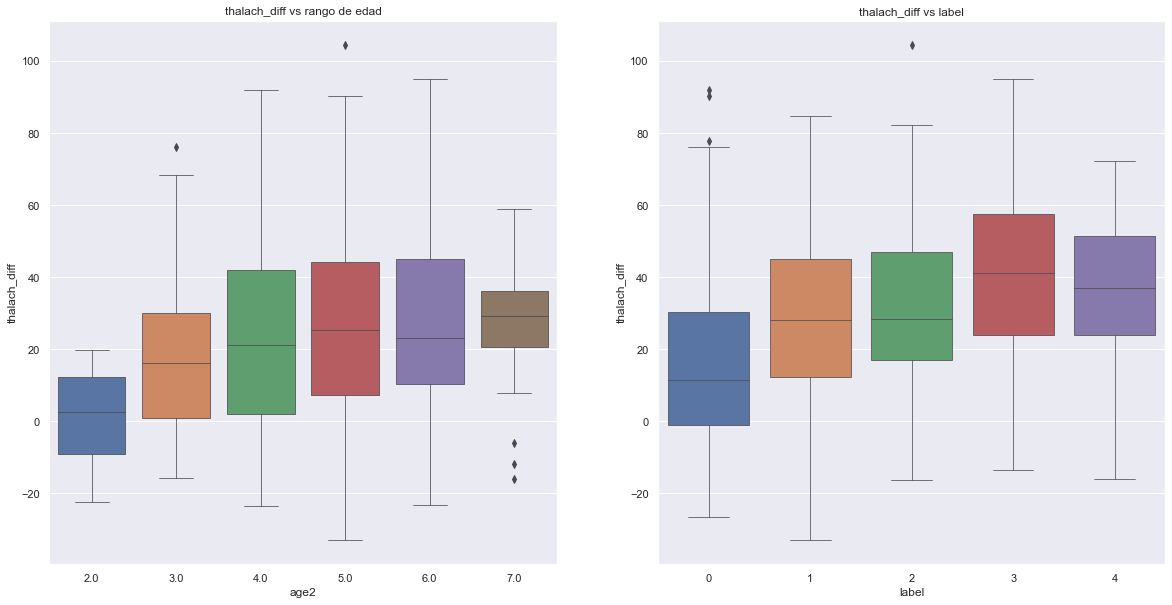

In [35]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

sns.boxplot(data=data, x='age2', y='thalach_diff', linewidth=0.75, ax=axes[0]).set(title='thalach_diff vs rango de edad')
sns.boxplot(data=data, x='label', y='thalach_diff', linewidth=0.75, ax=axes[1]).set(title='thalach_diff vs label')

**Oldpeak**

In [36]:
# Valores negativos de oldpeak también indican riesgo de enfermedad
data[data['oldpeak'] < 0]['label'].value_counts()

1    6
2    3
0    3
Name: label, dtype: int64

In [37]:
# Podemos tratar oldpeak en valor absoluto, y así evitamos que los valores negativos influyan en la distribución, y en el análisis 
data['oldpeak'] = np.abs(data['oldpeak'])

In [38]:
data[data['label'] == 0].groupby(['age2'])['oldpeak'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,2.0,4,0.0,0.000000,0.0
1,3.0,49,0.0,0.243750,3.5
2,4.0,123,0.0,0.268595,3.0
3,5.0,158,0.0,0.482000,4.2
4,6.0,56,0.0,0.774468,3.0
5,7.0,9,0.0,0.862500,2.0


In [39]:
data[data['label'] != 0].groupby(['age2'])['oldpeak'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,3.0,23,0.0,0.972727,3.8
1,4.0,79,0.0,1.162821,3.6
2,5.0,194,0.0,1.269274,5.6
3,6.0,149,0.0,1.396154,6.2
4,7.0,21,0.0,1.511111,4.0


Para los pacientes no enfermos, en media el valor está por debajo de 1, aunque hay algunos outliers. El valor tiende a incrementar con la edad.

Los enfermos tienen un valor de oldpeak mayor en media que los no enfermos, y el valor va creciendo con la edad, como con los pacientes no enfermos.

In [40]:
data[data['oldpeak'] >= 2]['label'].value_counts()

3    48
2    44
1    25
0    21
4    21
Name: label, dtype: int64

In [41]:
data[(data['oldpeak'] >= 0.75) & (data['oldpeak'] < 2)]['label'].value_counts()

0    75
1    67
3    37
2    33
4     5
Name: label, dtype: int64

In [42]:
data[(data['oldpeak'] >= 0.75) & (data['slope'].isin([2, 3]))]['label'].value_counts()

1    74
3    72
2    65
0    57
4    25
Name: label, dtype: int64

Valores por encima de 2 indican gran riesgo de enfermedad. Por debajo de 2, hasta 0.75, sigue habniendo riesgo de enfermedad aunque no tan alto. Pero el riesgo de enfermedad crece si el valor de `oldpeak` viene con una valor de `slope` 2 (plana) o 3 (descendente).

In [43]:
# Ahora vamos a crear una nueva variable para ver como difiere el valor de olpeak de cada paciente, 
# comparado para pacientes no enfermos en el mismo rango de enad
tmp = data[data['label'] == 0].groupby(['age2'])['oldpeak'].agg([np.mean])
tmp['mean'] = tmp['mean'].round(decimals=1)

In [44]:
data = pd.merge(data, tmp[['mean']], on="age2", how="left")
data['oldpeak_diff'] = data['oldpeak'] - data['mean']
data['oldpeak_diff'].describe()

count    805.000000
mean       0.378385
std        1.014180
min       -0.900000
25%       -0.300000
50%        0.000000
75%        1.000000
max        5.400000
Name: oldpeak_diff, dtype: float64

In [45]:
data = data.drop('mean', axis=1)

In [46]:
data[data['oldpeak_diff'] > 0.5]['label'].value_counts()

1    70
3    70
0    67
2    63
4    21
Name: label, dtype: int64

In [47]:
data[data['oldpeak_diff'] >= 0.75]['label'].value_counts()

3    59
2    56
1    52
0    52
4    21
Name: label, dtype: int64

In [48]:
data[(data['oldpeak_diff'] > 0.1) & (data['slope'].isin([2, 3]))]['label'].value_counts()

1    72
3    71
2    65
0    61
4    25
Name: label, dtype: int64

In [49]:
data[data['oldpeak_diff'] >= 0.5]['slope'].value_counts()

2.0    214
1.0     61
3.0     51
Name: slope, dtype: int64

- Un valor de oldpeak_diff por encima de 0.5  nos indica gran riesgo de estar enfermo. Y por encima de 1, el riesgo es mucho mayor.
- En combinación con slope 2/3, también es un buen indicador de riesgo
- En muchos casos, un valor grande de oldpeak_diff va asociado a pendiente 2-3 (más riesgo de enfermedad)


[Text(0.5, 1.0, 'oldpeak_diff vs label')]

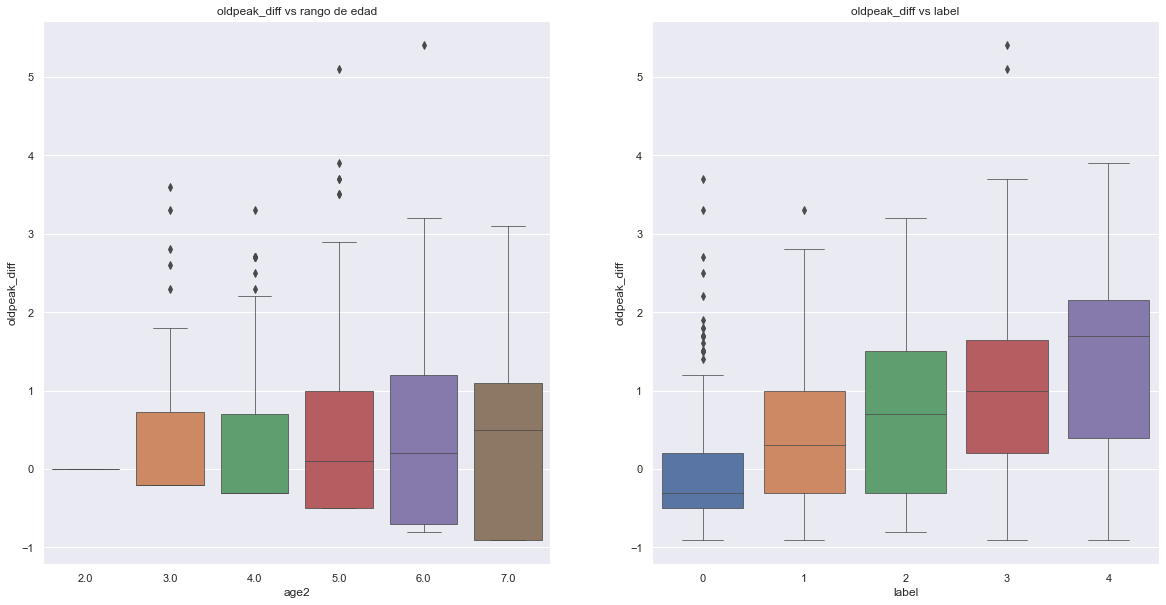

In [50]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

sns.boxplot(data=data, x='age2', y='oldpeak_diff', linewidth=0.75, ax=axes[0]).set(title='oldpeak_diff vs rango de edad')
sns.boxplot(data=data, x='label', y='oldpeak_diff', linewidth=0.75, ax=axes[1]).set(title='oldpeak_diff vs label')

- El valor de `oldpeak_diff` crece conforme crece el grado de gravedad de la enfermedad.
- El valor medio de `oldpeak_diff` no varía significativamente con la edad, pero la dispersión de los valores aumenta, ya que en el mismo grupo se encuentran pacientes no enfermos, con valores cercanos a cero e incluso negativos, y pacientes enfermos con valores más altos.

**Colesterol**

In [51]:
data[data['label'] == 0].groupby(['age2'])['chol'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,2.0,4,132.0,193.000000,243.0
1,3.0,49,0.0,224.787234,340.0
2,4.0,123,0.0,232.622807,412.0
3,5.0,158,0.0,232.111111,468.0
4,6.0,56,0.0,216.071429,564.0
5,7.0,9,0.0,193.000000,310.0


In [52]:
data[data['label'] != 0].groupby(['age2'])['chol'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,3.0,23,0.0,173.045455,529.0
1,4.0,79,0.0,200.858974,466.0
2,5.0,194,0.0,176.821053,603.0
3,6.0,149,0.0,159.632653,384.0
4,7.0,21,0.0,187.400000,322.0


In [53]:
data[data['chol'] >= 200]['label'].value_counts()

0    284
1    109
3     73
2     65
4     26
Name: label, dtype: int64

In [54]:
data[data['chol'] >= 300]['label'].value_counts()

0    48
2    16
1    15
3    14
4     5
Name: label, dtype: int64

In [55]:
data[data['chol'] >= 400]['label'].value_counts()

0    5
2    3
3    2
1    1
Name: label, dtype: int64

<AxesSubplot:xlabel='age', ylabel='chol'>

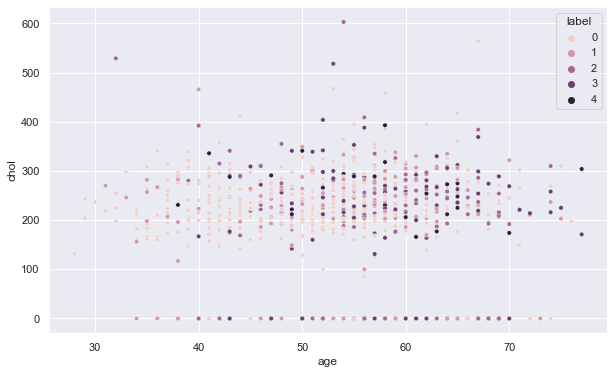

In [56]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='age', y='chol', hue='label', s=20)

- Tenemos bastantes outliers con valor 0, como ya vimos en la exploración inicial.
- Pacientes enfermos por debajo de los 50 años tienen en media nivel más alto de colesterol que los pacientes sanos, la diferencia es mayor en los más jóvenes.
- Pacientes con colesterol por encima de 300 tienen más riesgo de enfermedad. Por encima de 200 tenemos un 50% de enfermos, mientras que por encima de 400, la proporción se mantiene parecida a la que observamos con 300, no parece que el riesgo aumente considerablemente.  
- En cualquier caso, un nivel alto de colesterol no parece ser por sí solo, un buen predictor de enfermedad cardíaca.

**Presión arterial** 

In [57]:
data[data['label'] == 0].groupby(['age2'])['trestbps'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,2.0,4,120.0,130.000000,140.0
1,3.0,49,98.0,127.812500,190.0
2,4.0,123,100.0,126.733333,180.0
3,5.0,158,80.0,130.927632,180.0
4,6.0,56,102.0,136.021277,180.0
5,7.0,9,110.0,139.750000,160.0


In [58]:

data[data['label'] != 0].groupby(['age2'])['trestbps'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,3.0,23,92.0,117.652174,150.0
1,4.0,79,95.0,127.346154,160.0
2,5.0,194,0.0,135.541899,200.0
3,6.0,149,95.0,137.114504,200.0
4,7.0,21,115.0,143.055556,170.0


Por debajo de los 50 años, los enfermos tienen en media una tensión parecida a los no enfermos, pero a partir de los 50, los pacientes enfermos tienen una tensión mayor que los sanos. 

In [59]:
data[data['trestbps'] >= 170]['label'].value_counts()

0    12
1     9
3     9
2     5
4     3
Name: label, dtype: int64

In [60]:
data[(data['trestbps'] >= 120) & (data['trestbps'] < 180)]['label'].value_counts()

0    300
1    119
3     96
2     95
4     26
Name: label, dtype: int64

In [61]:
data[(data['trestbps'] <= 120)]['label'].value_counts()

0    147
1     69
2     32
3     23
4      8
Name: label, dtype: int64

<AxesSubplot:xlabel='age', ylabel='trestbps'>

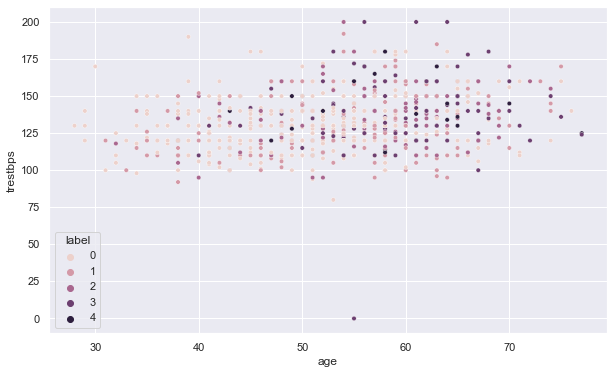

In [62]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='age', y='trestbps', hue='label', s=20)

- Observamos un outlier con valor 0, como ya vimos en la exploración inicial.
- La presión por encima de 170, tenemos una hipertensión extrema que nos indica mayor riesgo de enfermedad. 
- Entre 120 y 170 también tenemos patología de hipertensión,  más del 50% de pacientes con tensión alta están enfermos.
- Por debajo de 120 predominan los pacientes sanos

### Conclusiones - Factores de riesgo de enfermedad

- Edad por encima de 60 años (alto) o por encima de 50 (moderado)
- Nivel de colesterol en sangre por encima de 200 (moderado) o 300 (alto)
- Presión arterial por encima de 180 (alto), o mayor que 120 (moderado)
- Pendiente ST plana (2) o descendente (3) en combinación con oldpeak ST mayor que uno (alto) o por debajo de 1 (moderado) con oldpeak_diff mayor que 0.1
- Frecuencia cardíaca máxima alcanzada por debajo de 130, o más de 30 ppm por debajo de la frecuencia máxima teórica (200 - 0.7 * edad)
- Valores de 6 (medio) o 7 (alto) en el test de thalium
- Valores de 1, 2, 3 en la fluoroscopia
- Angina en ejercicio, si tiene angina de tipo 4 (alto) o tipo 2-3 (medio). 
- Diabéticos (fbs 1) con dolor de angina tipo 4 (medio)

Con estos factores de riesgo que hemos obtenido, podemos crear una columna para cuantificar cuanto riesgo tiene cada paciente. Remarcar que queremos calcular este factor ahora, antes de imputar los valores no informados, para evaluar el riesgo de los pacientes con los datos originales, ya que el algoritmo que usemos para imputar podría asignar  valores incorrectos a algunos pacientes, preferimos ser conservadores en este aspecto.

In [63]:
# vamos a crear una columna para cuantificar puntos de riesgo de enfermedad

data['oldpeak2'] = 0
data.loc[np.abs(data['oldpeak']) >= 1, 'oldpeak2'] = 1

data['risks'] = 0

data.loc[data['age2'] == 5, 'risks'] += 1
data.loc[data['age2'] == 6, 'risks'] += 1

data.loc[data['chol'] >= 200, 'risks'] += 1
data.loc[data['chol'] >= 300, 'risks'] += 1

data.loc[data['trestbps'] >= 120, 'risks'] += 1
data.loc[data['trestbps'] >= 170, 'risks'] += 1

data.loc[(data['thalach_diff'] >= 33) | (data['thalach'] <= 120), 'risks'] += 1


# cp 4 en combinación con otro factor de riesgo
data.loc[(data['cp'].isin([1, 4])) & ((data['fbs'] == 1) | (data['exang'] == 1) | (data['oldpeak2'] == 1) | (data['restecg'] != 0)) , 'risks'] += 1

# depresión ST por encima de la media, con pendiente plana o descendente
data.loc[((data['oldpeak_diff'] > 0.1) | (data['oldpeak'] >= 1)) & (data['slope'].isin([2, 3])), 'risks'] += 2


# vasos principales obstruidos
data.loc[data['ca'] == 1, 'risks'] += 2
data.loc[data['ca'] >= 2, 'risks'] += 1

# defecto de circulación de la sangre en el corazón
data.loc[data['thal'].isin([6,7]), 'risks'] += 2

<AxesSubplot:>

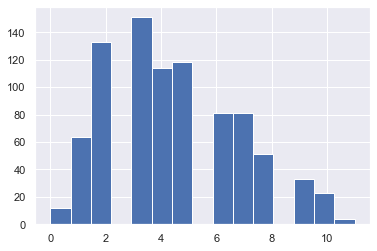

In [64]:
plt.figure(figsize=(6,4))
data['risks'].hist(bins=15)

In [65]:
data['risks'].describe()

count    865.000000
mean       4.463584
std        2.429826
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       11.000000
Name: risks, dtype: float64

In [66]:
data[data['label'] == 0].groupby(['age2'])['risks'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,2.0,4,1,1.500000,2
1,3.0,49,0,2.000000,6
2,4.0,123,0,2.398374,7
3,5.0,158,1,3.974684,9
4,6.0,56,1,4.410714,9
5,7.0,9,0,3.777778,9


In [67]:
data[data['label'] != 0].groupby(['age2'])['risks'].agg([len, np.min, np.mean, np.max]).reset_index()

,age2,len,amin,mean,amax
0,3.0,23,0,3.304348,7
1,4.0,79,0,4.759494,10
2,5.0,194,1,6.051546,11
3,6.0,149,1,5.610738,10
4,7.0,21,1,4.333333,9


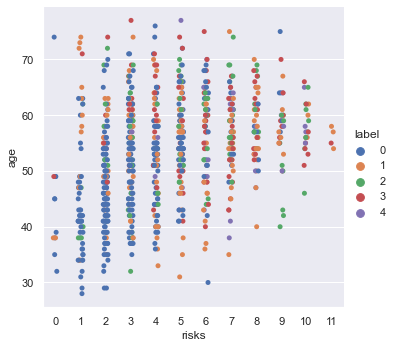

In [68]:
sns.catplot(data=data,x='risks',y='age',hue='label')

- Los pacientes enfermos tienen en media un valor de `risk` más alto que los no enfermos.
- El riesgo aumenta con la edad, tanto para enfermos como para no enfermos. 

## 2. Tratamiento de valores no informados y outliers 

In [69]:
# convertimos a NA las medidas de 0 para chol y trestbps 
data['chol'] = data['chol'].replace(0, np.nan)
data['trestbps'] = data['trestbps'].replace(0, np.nan)

In [70]:
# creamos 3 columnas para contar los nulos por fila, según el tipo de variable, y el total
data['num_na_count'] = data[numerical_vars].isnull().sum(axis=1)
data['cat_na_count'] = data[categorical_vars].isnull().sum(axis=1)
data['na_count'] = data['num_na_count'] + data['cat_na_count']
data['na_count'].value_counts()

0    286
3    217
2    196
4     82
7     43
1     25
8     11
5      4
6      1
Name: na_count, dtype: int64

Aunque normalmente es mejor tratar los valores no informados antes que los outliers, en este caso, como vamos a usar un algoritmo para imputar los nulos, creemos que es mejor tratar los outliers primero, para evitar que el algoritmo de imputación se vea afectado por los outliers. 

In [71]:
df = pd.DataFrame()

for var in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    tmp_data = data[var].dropna()
    q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
    iqr = q3 - q1
    lower, upper = round(q1 - iqr * 1.5, 2), round(q3 + iqr * 1.5, 2)
    n_out = tmp_data[(tmp_data < lower) | (tmp_data > upper)].shape[0]
    tmp_df = pd.DataFrame(data={"var": var, "min": tmp_data.min(), "lower_limit": lower, "Q1": q1, "IQR": iqr, "upper_limit": upper, "max": tmp_data.max(), "n_outliers": n_out}, index=[var])
    df = df.append(tmp_df)
    
df

,var,min,lower_limit,Q1,IQR,upper_limit,max,n_outliers
age,age,28.0,27.50,47.0,13.00,79.50,77.0,0
trestbps,trestbps,80.0,90.00,120.0,20.00,170.00,200.0,26
chol,chol,85.0,109.62,209.0,66.25,374.62,603.0,21
thalach,thalach,60.0,63.00,120.0,38.00,215.00,202.0,1
oldpeak,oldpeak,0.0,-2.25,0.0,1.50,3.75,6.2,13


In [72]:
# Tenemos un outlier de colesterol, en este rango de edad es muy raro tener colesterol tan bajo
data[data['chol'] < 100] 


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,split,age2,thalach_max,thalach_diff,oldpeak_diff,oldpeak2,risks,num_na_count,cat_na_count,na_count
750,56.0,1.0,4.0,120.0,85.0,0.0,0.0,140.0,0.0,0.0,NaN,NaN,NaN,0,train,5.0,160.8,20.8,-0.5,0,2,0,3,3


In [73]:
# Sustituimos el valor por 140, que es el mínimo que tenemos en nuestros datos para rangos de 40-50 y 50-60 (calculados arriba)
data.loc[data['chol'] <= 100, 'chol'] = 140

In [74]:
# Para la tensión máxima, dejamos el límite superior un poco por arriba del recomendado, para mantener diferenciados  
# a los pacientes con hipertensión extrema
data.loc[data['trestbps'] > 170, 'trestbps'] = 175
data.loc[data['trestbps'] < 90, 'trestbps'] = 90

In [75]:
data.loc[data['thalach'] < 63, 'thalach'] = 63
data.loc[data['oldpeak'] > 3.75, 'oldpeak'] = 3.75

In [76]:
# para ca, 9 es un outlier, el máximo resultado posible es un 3
data['ca'] = data['ca'].replace(9, 3)

Como ya hemos comentado anteriormente, los nulos para variables categóricas implican que al paciente no se le ha realizado una determinada prueba, por tanto, vamos a codificarlos como una nueva categoría, asignándole el `0`. Para ello, tenemos que "desplazar" algunas de las categorías que ya tienen un cero. La razón de asignarle el `0` es que algunos algoritmos pueden dar más importancia a un valor si es más grande, en el caso de que no usemos OHE, y queremos que el valor no informado sea la categoría menos importante. 

In [77]:
data[['fbs', 'restecg', 'exang', 'ca']] +=  1
data[categorical_vars] = data[categorical_vars].replace(np.nan, 0)

In [78]:
pd.DataFrame(data[numerical_vars + categorical_vars].isna().sum().to_dict(), index=[f"Missing values - total"])


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
Missing values - total,0,58,185,55,60,0,0,0,0,0,0,0,0


Ahora que ya hemos tratado los nulos en las variables categóricas y los outliers, vamos a imputar los valores no informados numéricos usando  MICEForest. MICEForest (Multiple Imputation by Chained Equations using Random Forests) es un algoritmo de imputación de valores faltantes que combina dos enfoques principales: MICE (Multiple Imputation by Chained Equations) y Random Forests. 

Posibles alternativas a MICEForest:

- Usar media o moda. No la mejor opción este caso, ya que hemos visto en el EDA que las variables numéricas varían significativamente con la edad y con el target. 
- MICE. Podría funcionar bien, pero MICEForest es robusto ante el ruido y puede manejar la no linealidad en los datos.
- KNNImputer. Podría ser una buena opción, pero no funciona muy bien con variables categóricas (usa distancia euclídea), y tenemos bastantes, más que numéricas.

In [79]:
!pip install miceforest

In [80]:
import miceforest as mf

In [81]:
# Solo dejamos fuera label y split, el resto de columnas que hemos añadido pueden ayudar al algoritmo a encontar los valores óptimos para imputar.
y = data['label']
data = data.drop(['label', 'split'], axis=1)


In [82]:
# Creamos el kernel
kernel = mf.ImputationKernel(
  data=data,
  save_all_iterations=True,
  random_state=1
)
# Lanzamos el algoritmo de imputación, dándole 50 iteraciones
kernel.mice(50)
# Obtenemos el dataset con los nulos imputados 
data = kernel.complete_data()

In [83]:
data['label'] = y

In [84]:
pd.DataFrame(data.isna().sum().to_dict(), index=[f"Missing values - total"])


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age2,thalach_max,thalach_diff,oldpeak_diff,oldpeak2,risks,num_na_count,cat_na_count,na_count,label
Missing values - total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ahora tenemos que volver a generar `thalach_diff` y `oldpeak_diff`, ya que los valores nulos que teníamos habrán sido imputados, pudiendo dar lugar a valores que no son correctos. 

In [85]:
data['thalach_max'] =  (200 - 0.7 * data['age'])
data['thalach_diff'] = data['thalach_max'] - data['thalach']

In [86]:
tmp = data[data['label'] == 0].groupby(['age2'])['oldpeak'].agg([np.mean])
tmp['mean'] = tmp['mean'].round(decimals=1)

In [87]:
data = pd.merge(data, tmp[['mean']], on="age2", how="left")
data['oldpeak_diff'] = data['oldpeak'] - data['mean']

In [88]:
data = data.drop('mean', axis=1)


Y una vez tenemos los datos limpios, lo guardamos en un nuevo archivo para usarlo en nuestros modelos de predicción.

In [89]:
data.to_csv('../dataset_clean.csv', index=False)

Ahora tenemos que realizar las mismas transformaciones en el dataset con los datos que tenemos que predecir.

In [90]:
data = pd.read_csv("datasets/test_dataset.csv", sep=',', decimal='.')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     float64
 2   cp        50 non-null     float64
 3   trestbps  48 non-null     float64
 4   chol      46 non-null     float64
 5   fbs       43 non-null     float64
 6   restecg   49 non-null     float64
 7   thalach   50 non-null     float64
 8   exang     50 non-null     float64
 9   oldpeak   48 non-null     float64
 10  slope     38 non-null     float64
 11  ca        12 non-null     float64
 12  thal      20 non-null     float64
dtypes: float64(13)
memory usage: 5.2 KB


In [91]:
# convertimos a NA las medidas de chol 0 
data['chol'] = data['chol'].replace(0, np.nan)
data['trestbps'] = data['trestbps'].replace(0, np.nan)
# pasamos a valor absoluto los valores negativos de oldpeak
data.loc[data['oldpeak'] < 0, 'oldpeak'] = np.abs(data['oldpeak'])

In [92]:
# creamos 3 columnas para contar los nulos por fila, según el tipo de variable, y el total
data['num_na_count'] = data[numerical_vars].isnull().sum(axis=1)
data['cat_na_count'] = data[categorical_vars].isnull().sum(axis=1)
data['na_count'] = data['num_na_count'] + data['cat_na_count']
data['na_count'].value_counts()

2    14
3    12
0    12
4     9
1     2
6     1
Name: na_count, dtype: int64

In [93]:
pd.DataFrame(data.isna().sum().to_dict(), index=[f"Missing values - total"])


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count
Missing values - total,0,0,0,2,16,7,1,0,0,2,12,38,30,0,0,0


In [94]:
data['age2'] = data['age'] // 10 
data['age2'].value_counts()

5.0    22
6.0    15
4.0     9
3.0     3
7.0     1
Name: age2, dtype: int64

In [95]:
data['oldpeak2'] = 0
data.loc[np.abs(data['oldpeak']) >= 1, 'oldpeak2'] = 1
data['oldpeak2'].value_counts()

1    30
0    20
Name: oldpeak2, dtype: int64

In [96]:
data['thalach_max'] =  (200 - 0.7 * data['age'])
data['thalach_diff'] = data['thalach_max'] - data['thalach']
data['thalach_diff'].describe()

count    50.000000
mean     26.476000
std      21.775202
min     -16.300000
25%       9.375000
50%      25.250000
75%      40.875000
max      74.400000
Name: thalach_diff, dtype: float64

In [97]:
data = pd.merge(data, tmp[['mean']], on="age2", how="left")
data['oldpeak_diff'] = data['oldpeak'] - data['mean']
data['oldpeak_diff'].describe()

count    48.00000
mean      0.88125
std       1.23799
min      -0.60000
25%      -0.30000
50%       0.70000
75%       1.60000
max       4.50000
Name: oldpeak_diff, dtype: float64

In [98]:
data = data.drop('mean', axis = 1)

In [99]:
data['oldpeak2'] = 0
data.loc[np.abs(data['oldpeak']) >= 1, 'oldpeak2'] = 1

data['risks'] = 0

data.loc[data['age2'] == 5, 'risks'] += 1
data.loc[data['age2'] == 6, 'risks'] += 1

data.loc[data['chol'] >= 200, 'risks'] += 1
data.loc[data['chol'] >= 300, 'risks'] += 1

data.loc[data['trestbps'] >= 120, 'risks'] += 1
data.loc[data['trestbps'] >= 170, 'risks'] += 1

data.loc[(data['thalach_diff'] >= 33) | (data['thalach'] <= 120), 'risks'] += 1


# cp 4 en combinación con otro factor de riesgo
data.loc[(data['cp'].isin([1, 4])) & ((data['fbs'] == 1) | (data['exang'] == 1) | (data['oldpeak2'] == 1) | (data['restecg'] != 0)) , 'risks'] += 1

# depresión ST por encima de la media, con pendiente plana o descendente
data.loc[((data['oldpeak_diff'] > 0.1) | (data['oldpeak'] >= 1)) & (data['slope'].isin([2, 3])), 'risks'] += 2


# vasos principales obstruidos
data.loc[data['ca'] == 1, 'risks'] += 2
data.loc[data['ca'] >= 2, 'risks'] += 1

# defecto de circulación de la sangre en el corazón
data.loc[data['thal'].isin([6,7]), 'risks'] += 2

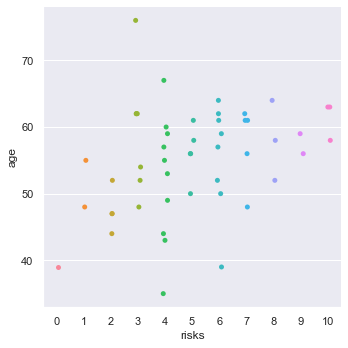

In [100]:
sns.catplot(data=data,x='risks',y='age')

<AxesSubplot:>

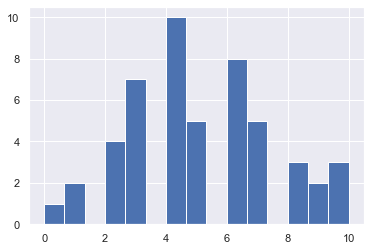

In [101]:
plt.figure(figsize=(6,4))
data['risks'].hist(bins=15)

In [102]:
df = pd.DataFrame()

for var in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    tmp_data = data[var].dropna()
    q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
    iqr = q3 - q1
    lower, upper = round(q1 - iqr * 1.5, 2), round(q3 + iqr * 1.5, 2)
    n_out = tmp_data[(tmp_data < lower) | (tmp_data > upper)].shape[0]
    tmp_df = pd.DataFrame(data={"var": var, "min": tmp_data.min(), "lower_limit": lower, "Q1": q1, "IQR": iqr, "upper_limit": upper, "max": tmp_data.max(), "n_outliers": n_out}, index=[var])
    df = df.append(tmp_df)
    
df

,var,min,lower_limit,Q1,IQR,upper_limit,max,n_outliers
age,age,35.0,33.50,50.00,11.000,77.50,76.0,0
trestbps,trestbps,94.0,89.25,120.00,20.500,171.25,190.0,1
chol,chol,153.0,103.50,216.75,75.500,405.50,491.0,2
thalach,thalach,92.0,75.00,120.00,30.000,195.00,179.0,0
oldpeak,oldpeak,0.0,-3.19,0.00,2.125,5.31,5.0,0


In [103]:
data.loc[data['trestbps'] > 170, 'trestbps'] = 175
data.loc[data['oldpeak'] > 3.75, 'oldpeak'] = 3.75
data.loc[data['chol'] > 350, 'chol'] = 350

In [104]:
data[['fbs', 'restecg', 'exang', 'ca']] +=  1
data[categorical_vars] = data[categorical_vars].replace(np.nan, 0)

Usamos el kernel de MICEForest entrenado con el training dataset para imputar los nulos en los datos de test. En un caso real (o en producción), haríamos esto, ya que no es eficiente entrenar un modelo nuevo cada vez que llega un nuevo paciente.


In [105]:
test_data = kernel.impute_new_data(data)

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           50 non-null     float64
 1   sex           50 non-null     float64
 2   cp            50 non-null     float64
 3   trestbps      48 non-null     float64
 4   chol          34 non-null     float64
 5   fbs           50 non-null     float64
 6   restecg       50 non-null     float64
 7   thalach       50 non-null     float64
 8   exang         50 non-null     float64
 9   oldpeak       48 non-null     float64
 10  slope         50 non-null     float64
 11  ca            50 non-null     float64
 12  thal          50 non-null     float64
 13  num_na_count  50 non-null     int64  
 14  cat_na_count  50 non-null     int64  
 15  na_count      50 non-null     int64  
 16  age2          50 non-null     float64
 17  oldpeak2      50 non-null     int64  
 18  thalach_max   50 non-null     fl

In [107]:
# Guardamos también el dataset para usarlo posteriormente para generar nuestras predicciones
data.to_csv('../test_dataset_clean.csv', index=False)

## 3. Preprocesado

In [108]:
# Leemos los CSVs con los datos limpios
data = pd.read_csv('datasets/dataset_clean.csv')
X_test = pd.read_csv('datasets/test_dataset_clean.csv')

Primero, veamos la distribución de valores del target para ver si está balanceado

In [109]:
counts = data['label'].value_counts()

print(counts) 

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

0    399
1    185
3    125
2    123
4     33
Name: label, dtype: int64


{0: 100.0, 1: 46.37, 3: 31.33, 2: 30.83, 4: 8.27}

Vemos que está desbalanceado ya que hay 399 filas pertenecientes a la clase 0 y unicamente 33 filas correspondientes la clase 4. Por tanto trataremos de balancear el dataset de la siguiente manera:

* Hacer undersampling de la clase 0: Borramos selectivamente filas de la clase 0 que puedan introducir ruido al modelo eliminandolas según la columna risks. En un principio se intentó realizar este punto haciendo subsampling aleatorio, pero por los resultados, llegamos a la conclusión de que era mejor seleccionar las filas nosotros.
* Hacer oversampling de la clase 4: Aplicamos Smote. Lo realizamos despues del One Hot Encoding

In [110]:
data_us = data.copy()
data_us = data.drop(data_us[(data['label'] == 0) & ( (data_us['risks'] >= 5 ) ) ].index) ## Los que label sea 0 y que el riesgo sea mayor o iagual a 5
data_us = data_us.drop(data_us[(data_us['label'] != 0) & (data_us['risks'] <= 1)].index) ## Los que label sea distinta de 0 y que el riesgo sea menor o igual que 1
data_us = data_us.drop(data_us[(data_us['risks'] == 0) & (data_us['label'] != 0)].index) ## Los que no tengan riesgo y que su label sea distinta de 0
data_us = data_us.reset_index(drop=True)
data_us.shape 

(750, 23)

In [111]:
data_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           750 non-null    float64
 1   sex           750 non-null    float64
 2   cp            750 non-null    float64
 3   trestbps      750 non-null    float64
 4   chol          750 non-null    float64
 5   fbs           750 non-null    float64
 6   restecg       750 non-null    float64
 7   thalach       750 non-null    float64
 8   exang         750 non-null    float64
 9   oldpeak       750 non-null    float64
 10  slope         750 non-null    float64
 11  ca            750 non-null    float64
 12  thal          750 non-null    float64
 13  num_na_count  750 non-null    int64  
 14  cat_na_count  750 non-null    int64  
 15  na_count      750 non-null    int64  
 16  age2          750 non-null    float64
 17  oldpeak2      750 non-null    int64  
 18  thalach_max   750 non-null    

Ahora seleccionamos las variables y aplicamos escalado a los datos y a test

In [112]:
categorical_vars = ['sex', 'exang', 'thal', 'fbs', 'restecg',  'cp', 'ca'] 
numerical_vars = ['age', 'trestbps', 'chol',  'thalach_diff', 'oldpeak', 'num_na_count', 'cat_na_count'] #'oldpeak_diff', 'thalach',

X = data_us
y = data_us['label']
X = X.drop('label', axis = 1)

X[categorical_vars] = (X[categorical_vars].astype(int)) # minmax_scale
X[numerical_vars] = scale(X[numerical_vars])
X = pd.concat([X[numerical_vars],X[categorical_vars]], axis=1)

X_test[categorical_vars] = (X_test[categorical_vars].astype(int)) # minmax_scale
X_test[numerical_vars] = scale(X_test[numerical_vars])
X_test = pd.concat([X_test[numerical_vars], X_test[categorical_vars]], axis=1)

Aplicamos One Hot Encoding a las variables categóricas de nuestros datos y a los de test

In [113]:
# ahora aplicamos OHE a las variables categóricas
ohe = OneHotEncoder(drop= 'first', sparse = False)

ohe_fit = ohe.fit(X[categorical_vars])
ohe_fit_test = ohe.fit(X_test[categorical_vars])

X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe_test = pd.DataFrame(ohe.fit_transform(X_test[categorical_vars]))

X_ohe.columns = ohe_fit.get_feature_names_out()
X_ohe_test.columns = ohe_fit_test.get_feature_names_out()


X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
X_test = pd.concat((X_ohe_test, X_test[numerical_vars].reset_index()), axis=1)

X.set_index('index')
X_test.set_index('index')

X.drop('index', axis=1, inplace=True)
X_test.drop('index', axis=1, inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex_1         750 non-null    float64
 1   exang_2       750 non-null    float64
 2   thal_3        750 non-null    float64
 3   thal_6        750 non-null    float64
 4   thal_7        750 non-null    float64
 5   fbs_1         750 non-null    float64
 6   fbs_2         750 non-null    float64
 7   restecg_1     750 non-null    float64
 8   restecg_2     750 non-null    float64
 9   restecg_3     750 non-null    float64
 10  cp_2          750 non-null    float64
 11  cp_3          750 non-null    float64
 12  cp_4          750 non-null    float64
 13  ca_1          750 non-null    float64
 14  ca_2          750 non-null    float64
 15  ca_3          750 non-null    float64
 16  ca_4          750 non-null    float64
 17  age           750 non-null    float64
 18  trestbps      750 non-null    

Como último paso de preprocesado, vamos a hacer oversampling aplicando SMOTE de la clase minoritaria, es decir, la clase 4. Ampliaremos el numero de muestras de esta clase a 90

In [114]:
# Aplicamos SMOTE y dividimos el dataset en train y validación
sm = SMOTE(sampling_strategy={4: 90}, random_state = 1, k_neighbors = 3) 
Xsm, ysm = sm.fit_resample(X, y)

## 4. Modelos y métrica

A la hora de seleccionar los modelos a emplear. Estuvimos haciendo pruebas, y llegamos a la conclusion de que los modelos basados en arboles y de gradiente eran los que mejor performance realizaban para poder predecir el riesgo de enfermedad cardiaca. Por tanto, como modelos utilizaremos:

* **Arboles**: Decission Trees, Randome Forest y Extra Trees
* **Gradiente**: XGBoost y LightGBM

In [115]:
!pip install lightgbm --upgrade

In [116]:
# Modelos
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier as XGBC # XGBoost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC # Arbol de decisión
from sklearn.ensemble import ExtraTreesClassifier as ETC # Extra trees
import lightgbm as lgb

In [117]:
# Importamos la métrica
from sklearn.metrics import f1_score as metric

## 5. GridSearch

In [118]:
# Función para hacer un split de train y val balanceado. Con n_samples especificamos el numero de muestras de cada clase que queremos en nuestra secuencia de validación

def balanced_test_split(X, y, n_samples=10, seed=1):
    test_idx = np.array([])

    for n in  y.unique():
        test_idx = np.concatenate([test_idx, X[y == n].sample(n_samples, random_state=seed).index], axis=0)
        
    X_v = X.loc[test_idx, :]
    y_v = y[test_idx]
    X_t = X.drop(index=test_idx)
    y_t = y.drop(index=test_idx)

    return (X_t, y_t, X_v, y_v)

Ahora que ya hemos realizado el preprocesado de nuestros datos vamos dividir el dataset en train y validación. Para ello utilizaremos la función anterior, de forma que el split de validación salga balanceado y se asemeje lo más posible a nuestros datos de test

In [119]:
X_train, y_train, X_val, y_val = balanced_test_split(Xsm, ysm, n_samples=10, seed=765)

In [120]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(757, 24)
(757,)
(50, 24)
(50,)


Para ver los modelos a utilizar vamos a realizar un Grid Search, de esta formapodemos medir todos los modelos que hemos importado, primero definimos algunos parámetros generales:

In [121]:
# Parámetros generales
random_state = 1;
scale_pos_weight = sum(np.array(y_train == 0)) / sum(np.array(y_train == 4))
n_jobs = multiprocessing.cpu_count() - 1

Ahora definimos los valores del grid para cada modelo que utilizaremos. Haremos un grid serach a parte para LightGBM por las peculiaridades que tiene a la hora de pasarle los datos

In [122]:
# Grid definition

# Arbol de Decision
max_depth_values_dt = [6, 20];
min_samples_split_values_dt = [2, 3, 4, 5];
min_samples_leaf_values_dt = [2, 3, 4, 5];
max_features_values_dt = [17, 18, 19];

# Random Forest
criterion_values_rf = ['gini']
min_samples_leaf_values_rf = [5, 10]
min_samples_split_values_rf = [2, 3, 4]
max_depth_values_rf = [11, 10]
max_features_values_rf = [15, 16, 17, 18]
n_estimators_values_rf = [75]

# Xgboost
n_estimators_values_xg = [30]
learning_rate_values = [0.1]
gamma_values = [0]
max_depth_values_xg = [4]
min_child_weight_values = [6]
subsample_values = [0.85]
colsample_bytree_values = [0.8]
lambda_values = [1]
alpha_values = [0]

In [123]:
# Diccionario con Parámetros para los modelos
params_values = [{'model': 'decision tree',
                 'max_depth': max_depth_values_dt,
                 'min_samples_split': min_samples_split_values_dt,
                 'min_samples_leaf': min_samples_leaf_values_dt,
                 'max_features': max_features_values_dt},
                 {'model': 'random forest',
                 'criterion': criterion_values_rf,
                 'max_depth': max_depth_values_rf,
                 'min_samples_split': min_samples_split_values_rf,
                 'min_samples_leaf': min_samples_leaf_values_rf,
                 'max_features': max_features_values_rf,
                 'n_estimators' : n_estimators_values_rf},
                 {'model': 'xgboost',
                 'n_estimators': n_estimators_values_xg,
                 'gamma' : gamma_values,
                 'learning_rate' : learning_rate_values,
                 'max_depth': max_depth_values_xg,
                 'min_child_weight': min_child_weight_values,
                 'subsample': subsample_values,
                 'colsample_bytree': colsample_bytree_values,
                 'lambda': lambda_values,
                 'alpha': alpha_values}]

In [124]:
# Cáculo del numero de iteraciones del Grid Search

total_iteraciones = 0
for params in params_values:
    if params['model'] == 'decision tree':
        n = len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'random forest':
        n = len(params['criterion'])*len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])*len(params['n_estimators'])
    elif params['model'] == 'knn':
        n = len(params['weights'])*len(params['n_neighbors'])*len(params['algorithm'])*len(params['leaf_size'])*len(params['metric'])   
    elif params['model'] == 'xgboost':
        n = len(params['n_estimators'])*len(params['learning_rate'])*len(params['gamma'])*len(params['max_depth'])*len(params['min_child_weight'])*len(params['subsample'])*len(params['colsample_bytree'])*len(params['lambda'])*len(params['alpha'])
    total_iteraciones = total_iteraciones + n;
    print(str(n)+ ' iteraciones de ' + str(params['model']))
print(str(total_iteraciones)+ ' iteraciones en total')

96 iteraciones de decision tree
48 iteraciones de random forest
1 iteraciones de xgboost
145 iteraciones en total


In [125]:
%%capture
# Grid Search

grid_results = pd.DataFrame();
num_iter = 0
for params in params_values:   
                
    # Decision Tree
    if params['model'] == 'decision tree':
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:  
                for min_samples_leaf in params['min_samples_leaf']:  
                    for max_features in params['max_features']:  
                        start = timeit.default_timer()
                
                        # Actualizar contador
                        num_iter += 1; 

                        # print control iteracion modelo
                        print('Inicio de iteracion ' + str(num_iter) + 
                              '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '\n')

                        # Entrenar modelo               
                        model = DTC(max_depth = max_depth, 
                                    min_samples_split = min_samples_split, 
                                    min_samples_leaf = min_samples_leaf,
                                    max_features = max_features,
                                    random_state = random_state)

                        model.fit(X_train, y_train)

                        # Generar predicciones
                        pred_train_p = model.predict(X_train)
                        pred_val_p = model.predict(X_val)

                        # Calcular métricas de evaluación
                        f1_train = metric(y_train, pred_train_p, average = 'micro')
                        f1_val = metric(y_val, pred_val_p, average = 'micro')
                        time = timeit.default_timer() - start

                        print('Fin de iteracion ' + str(num_iter) + 
                             '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '. AUC train = '  + str(f1_train) + 
                              ' -  AUC val = '  + str(f1_val)  + 
                              ' -  time = '  + str(time)  +
                              '\n')
                        
                        grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                             'params': [{'max_depth':[max_depth],
                                                                                      'min_samples_split':[min_samples_split],
                                                                                      'min_samples_leaf':[min_samples_leaf],
                                                                                      'max_features':[max_features]}],
                                                                               'f1_train':[f1_train],
                                                                              'f1_val':[f1_val],
                                                                              'time':[time]},
                                                                       columns=['model','params', 'f1_train', 'f1_val', 'time']), 
                                                           ignore_index=True)
    
    
    
    # Random Forest
    if params['model'] == 'random forest':
        for criterion in params['criterion']:
            for max_depth in params['max_depth']:
                for min_samples_split in params['min_samples_split']:  
                    for min_samples_leaf in params['min_samples_leaf']:  
                        for max_features in params['max_features']:  
                            for n_estimators in params['n_estimators']:
                                start = timeit.default_timer()

                                # Actualizar contador
                                num_iter += 1; 

                                # print control iteracion modelo
                                print('Inicio de iteracion ' + str(num_iter) + 
                                      '. criterion = ' + str(criterion) +
                                      '. max_depth = ' + str(max_depth) + 
                                      ', min_samples_split = '  + str(min_samples_split) +
                                      ', min_samples_leaf = '  + str(min_samples_leaf) +
                                      ', max_features = '  + str(max_features) +
                                      ', n_estimators = '  + str(n_estimators) +
                                      '\n')

                                # Entrenar modelo               
                                model = RFC(n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_samples_split = min_samples_split,
                                            min_samples_leaf = min_samples_leaf,
                                            max_features = max_features, 
                                            random_state = random_state,
                                            criterion = criterion,
                                            n_jobs = multiprocessing.cpu_count() - 1)

                                model.fit(X_train, np.array(y_train))

                                # Generar predicciones
                                pred_train_p = model.predict(X_train)
                                pred_val_p = model.predict(X_val)

                                # Calcular métricas de evaluación
                                f1_train = metric(y_train, pred_train_p, average = 'micro')
                                f1_val = metric(y_val, pred_val_p, average = 'micro')
                                time = timeit.default_timer() - start

                                print('Fin de iteracion ' + str(num_iter) + 
                                     '. criterion = ' + str(criterion) +
                                     '. max_depth = ' + str(max_depth) + 
                                      ', min_samples_split = '  + str(min_samples_split) +
                                      ', min_samples_leaf = '  + str(min_samples_leaf) +
                                      ', max_features = '  + str(max_features) +
                                      ', n_estimators = '  + str(n_estimators) +
                                      '. AUC train = '  + str(f1_train) + 
                                      ' -  AUC val = '  + str(f1_val)  + 
                                      ' -  time = '  + str(time)  +
                                      '\n')
                                grid_results = grid_results.append(pd.DataFrame(data={'model':'random forest',
                                                                                      'params': [{'criterion': [criterion],
                                                                                                  'max_depth_rf':[max_depth],
                                                                                                  'min_samples_split':[min_samples_split],
                                                                                                  'min_samples_leaf':[min_samples_leaf],
                                                                                                  'max_features':[max_features],
                                                                                                  'n_estimators_rf':[n_estimators]}],
                                                                              'f1_train':[f1_train],
                                                                              'f1_val':[f1_val],
                                                                              'time':[time]},
                                                                               columns=['model','params', 'f1_train', 'f1_val', 'time']), 
                                                                   ignore_index=True)
                        
    # XGBoost
    if params['model'] == 'xgboost':
        for n_estimators in params['n_estimators']:
            for learning_rate in params['learning_rate']:
                for gamma in params['gamma']:
                    for max_depth in params['max_depth']:
                        for min_child_weight in params['min_child_weight']:
                            for subsample in params['subsample']:
                                for colsample_bytree in params['colsample_bytree']:
                                    for lamda in params['lambda']:
                                        for alpha in params['alpha']:

                                            # Start timer
                                            start = timeit.default_timer()

                                            # Actualizar contador
                                            num_iter += 1;

                                            # print control iteracion modelo
                                            print('Inicio de iteracion ' + str(num_iter) + 
                                                    '. Parametro n_estimators = ' + str(n_estimators) + 
                                                    ', parametro learning_rate = ' + str(learning_rate) + 
                                                    ', parametro gamma = '  + str(gamma) +
                                                    ', parametro max_depth = '  + str(max_depth) +
                                                    ', parametro min_child_weight = '  + str(min_child_weight) +
                                                    ', parametro subsample = '  + str(subsample) +
                                                    ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                    ', parametro lambda = '  + str(lamda) +
                                                    ', parametro alpha = '  + str(alpha) + 
                                                    '\n')

                                            # Entrenar modelo
                                            model = XGBC(random_state = random_state,
                                                                    n_estimators = n_estimators,
                                                                    learning_rate = learning_rate,
                                                                    gamma = gamma,
                                                                    max_depth = max_depth,
                                                                    min_child_weight = min_child_weight ,
                                                                    subsample = subsample,
                                                                    colsample_bytree = colsample_bytree,
                                                                    num_parallel_tree = 25,
                                                                    nthread = 20,
                                                                    tree_method = 'hist',
                                                                    objective='multi:softmax',
                                                                    early_stopping_rounds=3,
                                                                    reg_lambda = lamda,
                                                                    reg_alpha = alpha,
                                                                    num_classes=5,
                                                                    n_jobs = multiprocessing.cpu_count() - 1)

                                            model.fit(X_train, np.array(y_train), eval_set=[(X_val, y_val)],)

                                            # Generar predicciones
                                            pred_train_p = model.predict(X_train)
                                            pred_val_p = model.predict(X_val)

                                            # Calcular métricas de evaluación
                                            f1_train = metric(y_train, pred_train_p, average = 'micro')
                                            f1_val = metric(y_val, pred_val_p, average = 'micro')
                                            time = timeit.default_timer() - start

                                            print('Fin de iteracion ' + str(num_iter) +  
                                                  ', parametro n_estimators = '  + str(n_estimators) +
                                                  ', parametro learning_rate = '  + str(learning_rate) +
                                                  ', parametro gamma = '  + str(gamma) +
                                                  ', parametro max_depth = '  + str(max_depth) +
                                                  ', parametro min_child_weight = '  + str(min_child_weight) +
                                                  ', parametro subsample = '  + str(subsample) +
                                                  ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                  ', parametro lambda = '  + str(lamda) +
                                                  ', parametro alpha = '  + str(alpha) + 
                                                  '. AUC train = '  + str(f1_train) + 
                                                  ' -  AUC val = '  + str(f1_val)  +
                                                  ' -  time = '  + str(time)  +
                                                  '\n')

                                            grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
                                                                                                  'params': [{'n_estimators':[n_estimators],
                                                                                                              'learning_rate':[learning_rate],
                                                                                                              'gamma':[gamma],
                                                                                                              'max_depth':[max_depth],
                                                                                                              'min_child_weight':[min_child_weight],
                                                                                                              'subsample':[subsample],
                                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                                              'lamda':[lamda],
                                                                                                              'alpha':[alpha]}],
                                                                                                  'f1_train':[f1_train],
                                                                                                  'f1_val':[f1_val],
                                                                                                  'time':[time]},
                                                                                            columns=['model','params', 'f1_train', 'f1_val', 'time']), 
                                                                       ignore_index=True)

Ahora hacemos el GridSerach con LightGBM, para ello hay que formatear los datos.

In [126]:
X_train_lgbm = X_train.copy()
X_val_lgbm = X_val.copy()
X_test_lgbm = X_val.copy()

#Hay que transformar los datasets a un formato específico
X_train_lgbm.columns = ["var_" + str(x) for x in range(X.shape[1])]
X_val_lgbm.columns = ["var_" + str(x) for x in range(X.shape[1])]
X_test_lgbm.columns = ["var_" + str(x) for x in range(X.shape[1])]
train_data = lgb.Dataset(data = X_train, label = y_train)
validation_data = train_data.create_valid(data = X_val, label = y_val)

In [127]:
# Definimos el modelo
lgbm = lgb.LGBMClassifier(objective = 'multiclass',
                         metric = 'multi_logloss',
                         is_unbalance = True,
                         num_class = 5)

# Entrenamos el modelo (no usamos constructor + fit, sino lgb.train)
param = {'num_iterations': [30, 50, 100],
         'min_gain_to_split': [0],
         'subsample': [0.8],
         'min_child_weight': [6],
         'num_leaves': [16, 32, 64],
         'feature_fraction': [0.8],
         'scale_pos_weight': [scale_pos_weight],
         'max_depth': [4],
         'boosting_type': ['gbdt'], #GradientBoostingDecisionTree
         'learning_rate': [0.1]}

# Ejecutamos el grid
grid = GridSearchCV(estimator = lgbm,
                    param_grid=param,
                    scoring = 'f1_micro',
                    n_jobs = multiprocessing.cpu_count()-1,
                    verbose=True
                   )


# Entrenamos
grid.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds = 10)])

print(f'Best params : {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 1.10991
Best params : {'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'min_gain_to_split': 0, 'num_iterations': 100, 'num_leaves': 16, 'scale_pos_weight': 3.7, 'subsample': 0.8}
Best score: 0.5628180550714534


Una vez ejecutados los grids vamos a almacenarlos todas las iteraciones realizadas en un diccionario para luego poder implementar nuestros modelos finales

In [128]:
grid_results.loc[len(grid_results), ['model', 'params', 'f1_val']] = ['lightgbm', grid.best_params_, grid.best_score_]

### 5.1 Resultados del GridSearch

Ahora veamos cuales son los modelos con mejor f1_score en validación

In [129]:
grid_results.groupby(['model'], sort=False)['f1_val'].max().sort_values()

model
random forest    0.520000
xgboost          0.540000
lightgbm         0.562818
decision tree    0.620000
Name: f1_val, dtype: float64

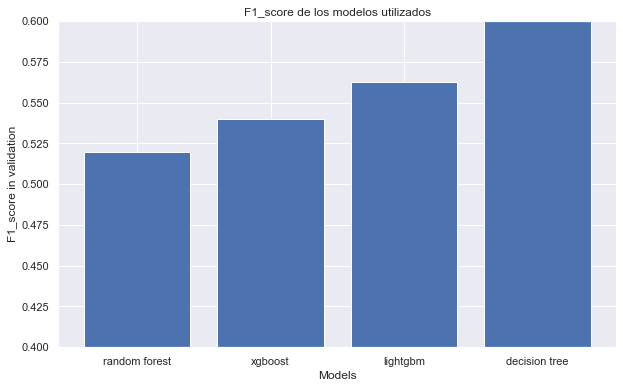

In [130]:
best_models = grid_results.groupby(['model'], sort=False)['f1_val'].max().sort_values()

best_models = best_models.to_dict()

# Convertir diccionario en dos listas
modelos = list(best_models.keys())
precisions = list(best_models.values())

# Crear gráfico de barras
fig = plt.figure(figsize=(10, 6))
plt.bar(modelos, precisions)

# Personalizar gráfico
plt.title('F1_score de los modelos utilizados')
plt.xlabel('Models')
plt.ylabel('F1_score in validation')
plt.ylim(0.4, 0.6)

# Mostrar gráfico
plt.show()

In [131]:
# Top 3 modelos para stacking
top = pd.DataFrame(grid_results.sort_values('f1_val', ascending=False))
top = top.head(10)

top

,model,params,f1_train,f1_val,time
86,decision tree,"{'max_depth': [20], 'min_samples_split': [5], ...",0.866579,0.620000,0.008249
145,lightgbm,"{'boosting_type': 'gbdt', 'feature_fraction': ...",NaN,0.562818,NaN
1,decision tree,"{'max_depth': [6], 'min_samples_split': [2], '...",0.675033,0.560000,0.007371
25,decision tree,"{'max_depth': [6], 'min_samples_split': [4], '...",0.675033,0.560000,0.007198
13,decision tree,"{'max_depth': [6], 'min_samples_split': [3], '...",0.675033,0.560000,0.007065
12,decision tree,"{'max_depth': [6], 'min_samples_split': [3], '...",0.661823,0.540000,0.007871
144,xgboost,"{'n_estimators': [30], 'learning_rate': [0.1],...",0.763540,0.540000,1.934648
40,decision tree,"{'max_depth': [6], 'min_samples_split': [5], '...",0.659181,0.540000,0.007184
28,decision tree,"{'max_depth': [6], 'min_samples_split': [4], '...",0.659181,0.540000,0.007032
24,decision tree,"{'max_depth': [6], 'min_samples_split': [4], '...",0.661823,0.540000,0.006976


El gráfico mostrado nos dice que los modelos que mejor score en validación tienen son random_forest, xgboost y lightgbm. Todos tienen un score parecido, mientras que extra trees y decission trees se quedan bastante por debajo. Por otro lado, vemos el top 10 de todos los modelos calculados en el grid. Ahor, agrupamos cada uno de los mejores modelos según su familia para poder elaborar la predicción final.

In [132]:
grouped = grid_results.groupby(['model'])

# Crear un dataframe vacío para almacenar los parámetros de cada modelo
best_params = pd.DataFrame(columns=['model', 'params'])

# Para cada grupo, encontrar el índice de la fila con el mayor valor de F1 en validación
for name, group in grouped:
    idxmax = group['f1_val'].idxmax()
    
    # Seleccionar la fila correspondiente en el dataframe original y extraer los parámetros
    params = group.loc[idxmax, 'params']
    
    # Agregar los parámetros al dataframe que los va a almacenar
    best_params = best_params.append({'model': name, 'params': params}, ignore_index=True)
    
best_params = best_params.to_dict()

# Mostrar el resultado final
best_params

{'model': {0: 'decision tree',
  1: 'lightgbm',
  2: 'random forest',
  3: 'xgboost'},
 'params': {0: {'max_depth': [20],
   'min_samples_split': [5],
   'min_samples_leaf': [2],
   'max_features': [19]},
  1: {'boosting_type': 'gbdt',
   'feature_fraction': 0.8,
   'learning_rate': 0.1,
   'max_depth': 4,
   'min_child_weight': 6,
   'min_gain_to_split': 0,
   'num_iterations': 100,
   'num_leaves': 16,
   'scale_pos_weight': 3.7,
   'subsample': 0.8},
  2: {'criterion': ['gini'],
   'max_depth_rf': [11],
   'min_samples_split': [2],
   'min_samples_leaf': [5],
   'max_features': [17],
   'n_estimators_rf': [75]},
  3: {'n_estimators': [30],
   'learning_rate': [0.1],
   'gamma': [0],
   'max_depth': [4],
   'min_child_weight': [6],
   'subsample': [0.85],
   'colsample_bytree': [0.8],
   'lamda': [1],
   'alpha': [0]}}}

## 6. Predicción final y postproceso

### 6.1 Random Forest

Para elaborar una primera predicción y poder evaluar nuestro modelo con los datos de test, vamos a probar cogiendo el random forest. Según indica nuestro grid, es el mejor de todos los modelos en validación

In [134]:
model = RFC(random_state=random_state,
              criterion=best_params['params'][2]['criterion'][0],
              max_depth=int(best_params['params'][2]['max_depth_rf'][0]),
              min_samples_split=int(best_params['params'][2]['min_samples_split'][0]),
              min_samples_leaf=int(best_params['params'][2]['min_samples_leaf'][0]),
              max_features=int(best_params['params'][2]['max_features'][0]),
              n_estimators=int(best_params['params'][2]['n_estimators_rf'][0]))

# Entrenar modelo
model.fit(X_train, y_train)

# Generar predicciones
pred_train_p = model.predict(X_train)
pred_y_val = model.predict(X_val) 
pred_test_p = model.predict(X_test)

# Calcular métricas de evaluación
f1_train = metric(y_train, pred_train_p, average = 'micro')
f1_val = metric(y_val, pred_val_p, average = 'micro')

print(f"F1 score (train): {f1_train}")
print(f"F1 score (val): {f1_val}")

F1 score (train): 0.857331571994716
F1 score (val): 0.54


Mostramos la matriz de confusión

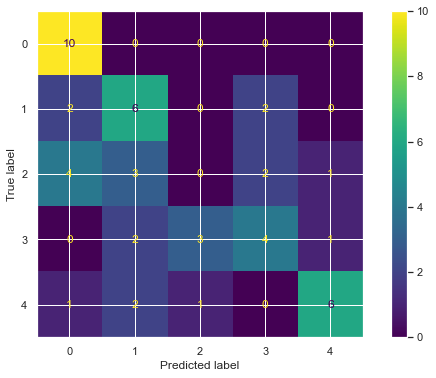

In [135]:
conf_matrix = confusion_matrix(y_val, pred_y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()

In [136]:
# Generamos df pred
pred_df_rf = pd.DataFrame({'ID': range(0, 50), 'label': pred_test_p.astype(int)})
pred_df_rf.to_csv('submissions/RandomForest.csv', index=False)
pred_df_rf.head()

,ID,label
0,0,0
1,1,3
2,2,1
3,3,1
4,4,0


Al subirlo a Kaggle obtenemos un score de 0.48 en los datos de test

### 6.2 XGBoost

Ahora probemos con XGBoost, segundo modelo mejor modelo del grid

In [138]:
model = XGBC(random_state=random_state,
                   n_estimators=int(best_params['params'][3]['n_estimators'][0]),
                   learning_rate=float(best_params['params'][3]['learning_rate'][0]),
                   gamma=float(best_params['params'][3]['gamma'][0]),
                   max_depth=int(best_params['params'][3]['max_depth'][0]),
                   min_child_weight=int(best_params['params'][3]['min_child_weight'][0]),
                   subsample=float(best_params['params'][3]['subsample'][0]),
                   colsample_bytree=float(best_params['params'][3]['colsample_bytree'][0]),
                   num_parallel_tree=25,
                   nthread=20,
                   tree_method='hist',
                   objective='multi:softmax',
                   early_stopping_rounds=5,
                   reg_lambda=float(best_params['params'][3]['lamda'][0]),
                   reg_alpha=float(best_params['params'][3]['alpha'][0]),
                   num_classes=5,
                   n_jobs=multiprocessing.cpu_count() - 1)

# Entrenar modelo
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Generar predicciones
pred_train_p = model.predict(X_train)
pred_y_val = model.predict(X_val) 
pred_test_p = model.predict(X_test)

# Calcular métricas de evaluación
f1_train = metric(y_train, pred_train_p, average = 'micro')
f1_val = metric(y_val, pred_val_p, average = 'micro')

print(f"F1 score (train): {f1_train}")
print(f"F1 score (val): {f1_val}")

[14:45:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_classes" } are not used.

[0]	validation_0-mlogloss:1.56676
[1]	validation_0-mlogloss:1.53387
[2]	validation_0-mlogloss:1.50376
[3]	validation_0-mlogloss:1.47690
[4]	validation_0-mlogloss:1.45307
[5]	validation_0-mlogloss:1.43231
[6]	validation_0-mlogloss:1.41326
[7]	validation_0-mlogloss:1.39555
[8]	validation_0-mlogloss:1.37979
[9]	validation_0-mlogloss:1.36482
[10]	validation_0-mlogloss:1.35216
[11]	validation_0-mlogloss:1.33888
[12]	validation_0-mlogloss:1.32754
[13]	validation_0-mlogloss:1.31588
[14]	validation_0-mlogloss:1.30512
[15]	validation_0-mlogloss:1.29484
[16]	validation_0-mlogloss:1.28333
[17]	validation_0-mlogloss:1.27426
[18]	validation_0-mlogloss:1.26653
[19]	validation_0-mlogloss:1.25825
[20]	validation_0-mlogloss:1.25047
[21]	validation_0-mlogloss:1.24298
[22]	validation_0-mlogloss:1.23519
[23]

Mostramos matriz de confusión

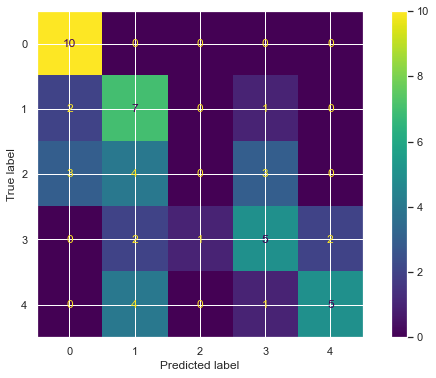

In [139]:
conf_matrix = confusion_matrix(y_val, pred_y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()

In [140]:
# Generamos df pred
pred_df_xgb = pd.DataFrame({'ID': range(0, 50), 'label': pred_test_p.astype(int)})
pred_df_xgb.to_csv('submissions/XGBoost.csv', index=False)
pred_df_xgb.head()

,ID,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,4


Con este segundo modelo, hemos vuelto a tener un score de 0.48 en Kaggle sobre sobre los datos de test.

Probemos con nuestro tercer mejor modelo, LightGBM

### 6.3. LightGMB

In [141]:
best_config = grid.best_params_

param = {'objective' : 'multiclass',
        'metric' : 'multi_logloss',
        'num_class' : 5,
        'num_iterations' : best_config['num_iterations'],
        'min_gain_to_split' : best_config['min_gain_to_split'],
        'subsample' : best_config['subsample'],
        'feature_fraction' : best_config['feature_fraction'],
        'scale_pos_weight' : best_config['scale_pos_weight'],
        'max_depth' : best_config['max_depth'],
        'boosting_type' : best_config['boosting_type'],
        'learning_rate' : best_config['learning_rate']}

model = lgb.train(param, train_data, valid_sets=[validation_data], callbacks=[lgb.early_stopping(stopping_rounds=6)])

pred_y_train = model.predict(X_train) 
pred_y_val = model.predict(X_val) 
pred_y_test = model.predict(X_test) 

# LighGBM predice probabilidades, por tanto tenemos que convertirlas a los valores de label
y_train_labels = pred_y_train.argmax(axis=1)
y_val_labels = pred_y_val.argmax(axis=1)
y_test_labels = pred_y_test.argmax(axis=1)



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 24
[LightGBM] [Info] Start training from score -0.939004
[LightGBM] [Info] Start training from score -1.554189
[LightGBM] [Info] Start training from score -1.947232
[LightGBM] [Info] Start training from score -1.901975
[LightGBM] [Info] Start training from score -2.247337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 6 rounds
[Light

In [142]:
print(f"F1 score (train): {metric(y_train, y_train_labels, average='micro')}")
print(f"F1 score (val): {metric(y_val, y_val_labels, average='micro')}")

F1 score (train): 0.8863936591809775
F1 score (val): 0.56


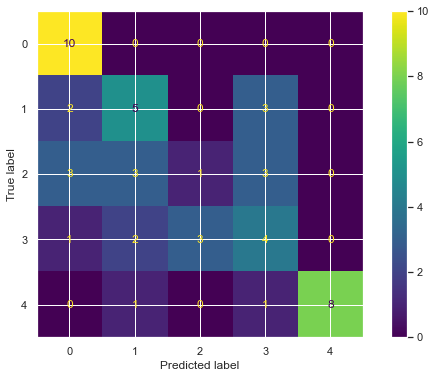

In [143]:
conf_matrix = confusion_matrix(y_val, y_val_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [144]:
# Generamos df pred
pred_df_lgbm = pd.DataFrame({'ID': range(0, 50), 'label': y_test_labels.astype(int)})
pred_df_lgbm.to_csv('submissions/LGBM.csv', index=False)
pred_df_lgbm.head()

,ID,label
0,0,0
1,1,1
2,2,3
3,3,1
4,4,1


Con este tercer mejor modelo obtenemos un score en test de 0.45, con lo que ya disminuimos nuestro indice de predicción

### 6.4 Decission Tree

In [145]:
model = DTC(max_depth = int(best_params['params'][0]['max_depth'][0]), #int(best_params['params'][0]['max_depth'][0]), 
                min_samples_split = int(best_params['params'][0]['min_samples_split'][0]),
                min_samples_leaf = int(best_params['params'][0]['min_samples_leaf'][0]),
                max_features = int(best_params['params'][0]['max_features'][0]), 
                random_state = random_state)

# Entrenar modelo
model.fit(X_train, y_train)

# Generar predicciones
pred_train_p = model.predict(X_train)
pred_y_val = model.predict(X_val) 
pred_test_p = model.predict(X_test)

# Calcular métricas de evaluación
f1_train = metric(y_train, pred_train_p, average = 'micro')
f1_val = metric(y_val, pred_val_p, average = 'micro')

print(f"F1 score (train): {f1_train}")
print(f"F1 score (val): {f1_val}")

F1 score (train): 0.8665785997357992
F1 score (val): 0.54


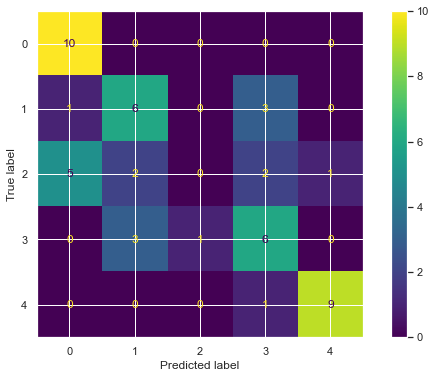

In [146]:
conf_matrix = confusion_matrix(y_val, pred_y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()

In [147]:
# Generamos df pred
pred_df_dt = pd.DataFrame({'ID': range(0, 50), 'label': pred_test_p.astype(int)})
pred_df_dt.to_csv('submissions/DecissionTree.csv', index=False)
pred_df_dt.head()

,ID,label
0,0,0
1,1,2
2,2,2
3,3,2
4,4,2


### 7. Voting Ensemble

Como paso final para tratar de mejorar el score obtenido en las predicciones de test mostradas anteriormente. Vamos a implementar un sistema de votación en el que se recojan las mejores predicciones que hemos ido subiendo a Kaggle, como criterio para escoger las mejores predicciones hemos tomado que solo cegeremos predicciones que tengan un score por encima de 0.48.

En este caso seleccionaremos las 8 mejores, los modelos con los que se han generado las predicciones son los que hemos empleado en el notebook, con otros parámetros que ibamos probando:

* **XGBoost**: f1_test = 0.51
* **XGboost**: f1_test = 0.48
* **LighGBM**: f1_test = 0.48
* **Random Forest**: f1_test = 0.48
* **Random Forest**: f1_test = 0.48
* **Decission Tree**: f1_test = 0.51
* **Decission Tree**: f1_test = 0.48


In [148]:
df = pd.DataFrame()

In [149]:
# Leemos la columna label de las predicciones generadas y las almacenamos en dataframe
for i in ['s1', 's2', 's3', 's4', 's5', 's6', 's7']:
    tmp = pd.read_csv(f'submissions/{i}.csv')
    df[i] = tmp['label']
    
df.head()

,s1,s2,s3,s4,s5,s6,s7
0,0,0,0,0,0,0,0
1,1,1,1,1,1,3,1
2,3,1,1,2,2,3,2
3,1,1,1,1,2,1,1
4,4,4,2,0,0,2,3


In [150]:
pred_y_test = df.mode(axis=1)[0]
pred_df = pd.DataFrame({'ID': df.index.values, 'label': pred_y_test.astype(int)})
pred_df.to_csv('submissions/ensemble_voting.csv', index=False)

In [151]:
pred_y_test.value_counts()

0.0    16
1.0    16
2.0     8
3.0     7
4.0     3
Name: 0, dtype: int64